## Import/init

In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl
import sys
from typing import Union, List, Type
from scipy.signal import savgol_filter


from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm


import scipy as sc
from scipy.fftpack import fft, rfft

In [2]:
import qcodes as qc
from qcodes import load_by_id
from qcodes import validators
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.database import initialise_database
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers

In [3]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

from pytopo.mplplots.init_nb_plotting import *

from pytopo.qctools.measurement import MeasurementExt
from pytopo.qctools import instruments as instools; reload(instools)

qc.config['core']['db_location'] = r"C:/Users/Administrator/OneDrive/BF5/Data/experiments.db"
initialise_database()

In [4]:
from v0_utils.hwsweep import \
    HardwareSweep
    
# from v0_utils.sequence_generators import \
#     RepeatingStaircaseRampGenerator
    
# from v0_utils.awg_sequencers import \
#     OneChannelOneMarkerAwgSequencer, \
#     AwgSequencer

from v0_utils.qcodes_tools import \
    instrument_factory, init_or_create_database, load_or_create_experiment, \
    add_parameter_to_instrument, \
    DelegateParameter, VirtualInstrument

In [5]:
#Load instruments using new init file
from v0_utils.InitFridge import QT5_init
station = QT5_init(DMM1=True, DMM2=True, DMM3=True, lockin1=True, lockin2=True, mdac=True, yokogawa=True, SGS1=False, 
                   SGS2=False, scope=True, rigol=True, awg_5208=False, magnet=False, alazar=False)

Connected to: Keysight Technologies 34465A (serial:MY57505814, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.85s
Connected to: Keysight Technologies 34465A (serial:MY57507997, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.30s
Connected to: Keysight Technologies 34465A (serial:MY57505806, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.31s
Connected to: Stanford_Research_Systems SR860 (serial:003231, firmware:v1.51) in 0.13s
Connected to: Stanford_Research_Systems SR860 (serial:003232, firmware:v1.51) in 0.11s
Connected to: YOKOGAWA GS210 (serial:91U100329, firmware:2.02) in 0.03s


C:\ProgramData\Anaconda3\envs\qcodes\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040037003E, firmware:1.4) in 5.28s
Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY58150108, firmware:06.20.00620) in 0.04s
Connected to: Rigol Technologies DG1062Z (serial:DG1ZA195206768, firmware:03.01.12) in 0.06s


c:\users\administrator\onedrive\bf5\code\qcodes\qcodes\instrument\parameter.py:247: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '
Snapshot: Could not update parameter: current_range on yokogawa
Snapshot: Could not update parameter: current on yokogawa
Snapshot: Could not update parameter: period on rigol_burst
Snapshot: Could not update parameter: period on rigol_burst


## Measurement and configuration classes

### Standard DAC/IVVI config

In [6]:
class ConversionParameter(Parameter):
    
    def __init__(self, name, src_param, get_conv, set_conv=None, **kw):
        super().__init__(name, **kw)
        self.src_param = src_param
        self.get_conv = get_conv
        self.set_conv = set_conv
    
    def get_raw(self):
        return self.get_conv(self.src_param())
    
    def set_raw(self, value):
        if self.set_conv is None:
            raise NotImplementedError("No set conversion implemented.")
        
        return self.src_param(self.set_conv(value))
    

class IVVISetup(Instrument):
    
    def __init__(self, name, ivvi, **kw):
        super().__init__(name, **kw)
        
        self.ivvi = ivvi
        
        self.add_parameter('voltage_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-3)
        self.add_parameter('current_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-7)
        self.add_parameter('iso_in_multiplier', get_cmd=None, set_cmd=None,
                           initial_value=1e-2)
        self.add_parameter('gate_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=15)
        
        self.add_parameter('M1b_gain', get_cmd=None, set_cmd=None, initial_value=1e6)
        self.add_parameter('M1b_mode', get_cmd=None, set_cmd=None, 
                           vals=validators.Enum('low_noise', 'low_R_in'), 
                           initial_value='low_noise')
        self.add_parameter('M1b_R_in', get_cmd=self._get_M1b_R_in)
        
        self.add_parameter('M2m_Vgain', get_cmd=None, set_cmd=None, initial_value=1e3)

        for i in range(1, self.ivvi._numdacs + 1):       
            self.add_parameter('dac{}'.format(i), unit='V',
                               get_cmd=self.ivvi._gen_ch_get_func(self._get_dac, i),
                               set_cmd=self.ivvi._gen_ch_set_func(self._set_dac, i))
            
    def _get_M1b_R_in(self):
        if self.M1b_mode() == 'low_noise':
            return 2e3 + 1e-3 * self.M1b_gain()
        elif self.M1b_mode() == 'low_R_in':
            return 2e3 + 1e-4 * self.M1b_gain()
            
    def _get_dac(self, ch):
        if ch == 6:
            return self.ivvi.set('dac{}'.format(ch)) * 1e-3 * self.gate_multiplier()
        else:
            return self.ivvi.get('dac{}'.format(ch)) * 1e-3 * self.voltage_multiplier()
    
    def _set_dac(self, ch, val):
        if ch == 3:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.gate_multiplier())
        else:
            return self.ivvi.set('dac{}'.format(ch), val * 1e3 / self.voltage_multiplier())
    


class DC_Setup(Instrument):
    
    def __init__(self, name, mdac, didv_lockin, Imeas_DMM, Vmeas_DMM, Vmeas_Ibias_DMM, Isrc, **kw):
        super().__init__(name, **kw)
        
        self.mdac = mdac
        
        self.didv_lockin = didv_lockin
        
        self.Imeas_DMM = Imeas_DMM
        
        self.Vmeas_DMM = Vmeas_DMM
        
        self.Vmeas_Ibias_DMM = Vmeas_Ibias_DMM
        
        self.Isrc = Isrc
        
        self.add_parameter('current_multiplier', get_cmd=None, set_cmd=None, 
                           initial_value=1e-7)
        
        self.add_parameter('DL1211_sens', get_cmd=None, set_cmd=None, initial_value=1e-7)
        
        self.add_parameter('DL1211_post_gain', get_cmd=None, set_cmd=None, initial_value=1.)
        
        self.add_parameter('DL1211_R_in', get_cmd=self._get_DL1211_R_in)
        
        self.add_parameter('DL1211_gain', get_cmd=self._get_DL1211_gain)
        
        self.add_parameter('NF_Vgain', get_cmd=None, set_cmd=None, initial_value=1e2)
        
        self.add_parameter('DC_Vbias_atten', get_cmd=None, set_cmd=None, initial_value=781.)
        
        self.add_parameter('AC_Vbias_atten', get_cmd=None, set_cmd=None, initial_value=1e5)
        
        self.add_parameter('DC_didv_bias', get_cmd=self._get_dc_didv_bias, set_cmd=self._set_dc_didv_bias)
        
        self.add_parameter('AC_didv_bias', get_cmd=self._get_ac_didv_bias, set_cmd=self._set_ac_didv_bias)
        
        self.add_parameter('SR560_gain', get_cmd=None, set_cmd=None, initial_value=100.)
        
        self.add_parameter('i_measurement', parameter_class=ConversionParameter, unit='A',
                         src_param=self.Imeas_DMM.volt, get_conv=lambda x: x / self.DL1211_gain())

        self.add_parameter('v_measurement', parameter_class=ConversionParameter, unit='V',
                          src_param=self.Vmeas_DMM.volt, get_conv=lambda x: x/self.SR560_gain())
        
        self.add_parameter('line_R', get_cmd=None, set_cmd=None, initial_value=13.4e3)
        
        self.add_parameter('R_s', get_cmd=self._get_R_s, set_cmd=None)
        
        self.add_parameter('g_measurement', parameter_class=ConversionParameter, unit='2e2/h',
                         src_param=self.didv_lockin.X, get_conv=lambda x: 12906/(self.AC_didv_bias()*self.DL1211_gain()/x - self.R_s()))
        
        self.add_parameter('SR560_gain_2', get_cmd=None, set_cmd=None, initial_value = 1e3)
        
        self.add_parameter('Ibias_R', get_cmd=None, set_cmd=None, initial_value = 1e6)
        
        self.add_parameter('v_meas_I_bias', parameter_class=ConversionParameter, unit='V',
                          src_param=self.Vmeas_Ibias_DMM.volt, get_conv=lambda x: x/self.SR560_gain_2())
        
        self.add_parameter('Ibias', get_cmd=self._get_Ibias, set_cmd=self._set_Ibias)
        
        self.add_parameter('Vbg_amplification', get_cmd=None, set_cmd=None, initial_value = 1.)
        
        self.add_parameter('Vbg', get_cmd=self._Vbg_get, set_cmd=self._Vbg_set)

            
    def _get_DL1211_R_in(self):
        Sens_Rin = {1e-3: 0.5, 1e-4: 0.5, 1e-5: 2, 1e-6: 20, 1e-7: 200, 1e-8: 2e3, 1e-9: 20e3, 1e-10: 200e3, 1e-11: 2e6}
        Rin = Sens_Rin[self.DL1211_sens()]
        return Rin
        
    def _get_DL1211_gain(self):
        gain = -1/(self.DL1211_sens()*self.DL1211_post_gain())
        return gain
    
    def _get_dc_didv_bias(self):
        bias = self.mdac.ch63.voltage()/self.DC_Vbias_atten()
        return bias
    
    def _set_dc_didv_bias(self, bias):
        dac_setting = bias*self.DC_Vbias_atten()
        return self.mdac.ch63.voltage(dac_setting)
    
    def _get_ac_didv_bias(self):
        bias = self.mdac.ch64.amplitude()/(self.AC_Vbias_atten()*2*np.sqrt(2))
        return bias
    
    def _set_ac_didv_bias(self, bias):
        dac_setting = bias*self.AC_Vbias_atten()*2*np.sqrt(2)
        return self.mdac.ch64.amplitude(dac_setting)
    
    def _get_R_s(self):
        Rs = self.line_R() + self.DL1211_R_in()
        return Rs
    
    def _get_Ibias(self):
        Ibias = self.mdac.ch62.voltage()/self.Ibias_R()
        return Ibias
    
    def _set_Ibias(self, Ibias):
        dac_setting = Ibias*self.Ibias_R()
        return self.mdac.ch62.voltage(dac_setting)
    
    def _Vbg_get(self):
        Vbg = self.mdac.ch61.voltage()*self.Vbg_amplification()
        return Vbg
    
    def _Vbg_set(self, Vbg):
        dac_setting = Vbg/self.Vbg_amplification()
        return self.mdac.ch61.voltage(dac_setting)
            

In [7]:
#Function to call after instantiation dc_setup.  Will initialize the MDAC + lockin combination for dI/dV measurements
def setup_mdac_didv(dc_setup, dc_bias_ch, ac_bias_ch, freq=87., rms_ampl=10e-6):
    dc_bias_ch.voltage(0)
    ac_bias_ch.voltage(0)
    
    ac_bias_ch.dac_output('close')
    dc_bias_ch.dac_output('close')
    ac_bias_ch.smc('close')
    dc_bias_ch.smc('close')
    
    dc_setup.didv_lockin.input_config('a')
    dc_setup.didv_lockin.filter_slope(24)
    dc_setup.didv_lockin.adv_filter('ON')
    dc_setup.didv_lockin.harmonic(1)
    dc_setup.didv_lockin.phase(0)
    dc_setup.didv_lockin.input_coupling('ac')
    dc_setup.didv_lockin.input_shield('float')
    dc_setup.didv_lockin.signal_input('voltage')
    dc_setup.didv_lockin.input_range(0.03)
    dc_setup.didv_lockin.sensitivity(0.001)
    dc_setup.didv_lockin.sync_filter('OFF')
    dc_setup.didv_lockin.time_constant(0.1)
    
    dc_setup.didv_lockin.external_reference_trigger('POSTTL')
    dc_setup.didv_lockin.external_reference_trigger_input_resistance(1)
    dc_setup.didv_lockin.reference_source('EXT')
    
    
    ac_bias_ch.awg_sine(freq, 1, offset=0, phase=0)
    dc_setup.AC_didv_bias(rms_ampl)
    
    
def setup_yokogawa_Ibias(dc_setup):
    dc_setup.Isrc.output('off')
    dc_setup.Isrc.source_mode('CURR')
    dc_setup.Isrc.current(0.0)
    dc_setup.Isrc.voltage_limit(1)
    dc_setup.Isrc.current_range(0.001)
    dc_setup.Isrc.output('on')
    
def setup_mdac_Ibias(dc_setup, Ibias_ch):
    Ibias_ch.voltage(0)
    Ibias_ch.dac_output('close')
    Ibias_ch.smc('close')
    
    dc_setup.Vmeas_Ibias_DMM.NPLC(1)


In [8]:
#Instantiate measurement class and setup MDAC+lockin for dI/dV measurements without breaking the MDAC
dc_setup = create_inst(DC_Setup, 'dc_setup', mdac=station.mdac, didv_lockin=station.lockin1, Imeas_DMM=station.DMM1, 
                       Vmeas_DMM=station.DMM2,Vmeas_Ibias_DMM=station.DMM3, Isrc=station.yokogawa, force_new_instance=True)

setup_mdac_didv(dc_setup, dc_bias_ch=dc_setup.mdac.ch63, ac_bias_ch=dc_setup.mdac.ch64, freq = 85, rms_ampl=10e-6)
setup_mdac_Ibias(dc_setup, Ibias_ch=dc_setup.mdac.ch62)

In [9]:
line_r = 15e3 + 3.4e3 #1.7e3 from each Qfilter, 5e3 for DC-only on PCB, 10e3 for RF on PCB, 3e3 for 8x MUX bias-T
dc_setup.line_R(line_r)
print('Total series resistance = ', dc_setup.R_s())

dc_setup.Imeas_DMM.NPLC(1)
dc_setup.Vmeas_DMM.NPLC(1)

Total series resistance =  18600.0


In [115]:
dc_setup.DL1211_post_gain(0.1)

## Sanity checks with simple resistors

### dI/dV measurement

In [10]:
#Start user settings
biasvals = np.linspace(-4e-3, 4e-3, 101)
#End user settings

exp = select_experiment('Code_testing', '1M_Resistor')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(dc_setup.DC_didv_bias)
meas.register_parameter(dc_setup.i_measurement, setpoints=[dc_setup.DC_didv_bias, ])
meas.register_parameter(dc_setup.v_measurement, setpoints=[dc_setup.DC_didv_bias, ])
meas.register_parameter(dc_setup.g_measurement, setpoints=[dc_setup.DC_didv_bias, ])


with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for b in biasvals:
        dc_setup.DC_didv_bias(b)
        datasaver.add_result((dc_setup.DC_didv_bias, b), 
                             (dc_setup.i_measurement, dc_setup.i_measurement()),
                             (dc_setup.v_measurement, dc_setup.v_measurement()),
                             (dc_setup.g_measurement, dc_setup.g_measurement()))                             

Starting experimental run with id: 18


### V-I measurement

In [11]:
#Start user settings
Ibiasvals = np.linspace(-100e-9, 100e-9, 101)
#End user settings

exp = select_experiment('Code_testing', '16k_Resistor')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(dc_setup.Ibias)
meas.register_parameter(dc_setup.v_meas_I_bias, setpoints=[dc_setup.Ibias, ])


with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for I in Ibiasvals:
        dc_setup.Ibias(I)
        datasaver.add_result((dc_setup.Ibias, I), 
                             (dc_setup.v_meas_I_bias, dc_setup.v_meas_I_bias()),
                             )     

Starting experimental run with id: 19


### Lockin hardware sweep

#### Create the signal

In [11]:
fast_ramp = RepeatingStaircaseRampGenerator('fast_staircase_ramp')

In [1]:
## Create AWG signal

fast_ramp.sample_rate(10e3)

fast_ramp.start_ramp_voltage(-0.025)
fast_ramp.finish_ramp_voltage(0.025)
fast_ramp.n_steps(10)  # 30
fast_ramp.n_repetitions(1)  # 20
fast_ramp.settlement_time(0.005)  # 0.103
fast_ramp.lockin_integration_time(0.005)  # 0.021
fast_ramp.restart_compensation(100 * fast_ramp.settlement_time())

# Convenient vectors for plotting
time_axis_points = fast_ramp.get_trigger_moments_vector()
gate_voltage_points = fast_ramp.values_vector()

NameError: name 'fast_ramp' is not defined

<IPython.core.display.Javascript object>


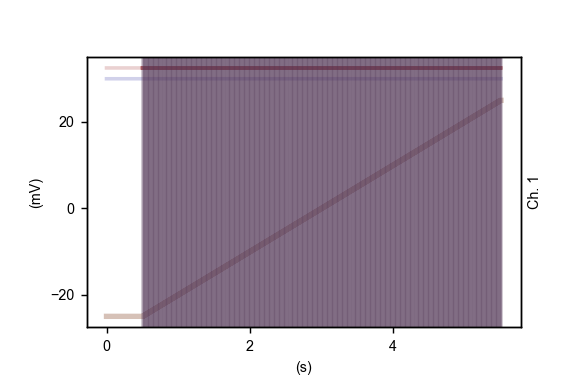

In [13]:
# Sanity check :)
fast_ramp.plot_broadbean_sequence()

In [52]:
awg_sequencer.sequence_gen.n_step

101

#### Lockin hardware sweep measurement class

In [14]:
class AwgLockInVoltageRampSweep(HardwareSweep):
    """
    This class implements "hardware" sweep that is performed by AWG sequencer, 
    and 3 lock-ins are measuring values while AWG is emitting a signal.
    
    Structure of this object:
    * The object of this class holds references to AWG sequencer and to the lock-ins.
    * Moreover, it defines 3 parameters which correspond to the outputs of the 3 lock-ins.
    * The 'run' method implements the actual measurement where lock-ins acquire data
      while the device under measurement is excited by signals from AWG, and the acquired
      data is then available through the 3 parameters presented above.
    """
    
    def __init__(self,
                 name: str,
                 awg_sequencer_obj: Type[AwgSequencer],
                 lockin1: Type[SR86x],
                 lockin2: Type[SR86x],
                 lockin3: Type[SR86x],
                 **kwargs):
        super().__init__(name, **kwargs)
        
        # AWG sequencer
        self.add_submodule(name='awg_sequencer',
                           submodule=awg_sequencer_obj)
        self.delegate_attr_objects = ['awg_sequencer']

        # Lock-in amplifiers
        self.add_submodule(name='lockin1',
                           submodule=lockin1)
        self.add_submodule(name='lockin2',
                           submodule=lockin2)
        self.add_submodule(name='lockin3',
                           submodule=lockin3)
        self._lockins = [self.lockin1, self.lockin2, self.lockin3]
        
        self._capture_variable_name = "X"
        self._setup_capture_config_for_lockins()

        # Parameters that are linked to outputs of lock-in buffers
        self.add_parameter('measured_voltage_at_triggers_lockin_1',
                           DelegateParameter,
                           source=self.lockin1.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 1 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 1 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_2',
                           DelegateParameter,
                           source=self.lockin2.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 2 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 2 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_3',
                           DelegateParameter,
                           source=self.lockin3.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 3 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 3 amplifier"
                           )
        
    @property
    def lockins(self):
        return self._lockins
       
    def _setup_capture_config_for_lockins(self):
        for lockin in self.lockins:
            lockin.input_config('a')  # within "voltage" block
            lockin.buffer.capture_config(self._capture_variable_name)

    def run(self):
        try:
            trigger_count = self.awg_sequencer.sequence_gen.n_all_steps()
            
            for lockin in self.lockins:
                lockin.buffer.set_capture_length_to_fit_samples(trigger_count)
                lockin.buffer.start_capture("ONE", "SAMP")
            
            self.awg_sequencer.awg.play()
            
            for lockin in self.lockins:
                lockin.buffer.wait_until_samples_captured(trigger_count)
                lockin.buffer.stop_capture()
                lockin.buffer.get_capture_data(trigger_count)   # this loads data from buffer 
                                                               # to driver's "buffer readout" fields in memory
                
                
            

#             # Alternatively, this method could have been returning the data 
#             # instead of using the driver's buffer readout
#             # parameters. But in this case, the occuring boilerplate code
#             # within the measurement context manager should be
#             # taken care of (for example, via Wolfgangs MeasurementExt,
#             # HardwareSweepDetector, etc.)
#             voltage_axis_points_dict = {}
#             for lockin in self.lockins:
#                 lockin_data = lockin.buffer.get_capture_data(trigger_count)
#                 voltage_axis_points_dict[lockin.name] = lockin_data[self._capture_variable_name]
#             return voltage_axis_points_dict
        
        finally:
            self.awg_sequencer.awg.stop()

#### Setup station

In [15]:
# Station 
#   |- AwgLockInVoltageRampSweep (HardSweep)
#   |   |    connects the signal source (AWG) with detector (lock-in),
#   |   |    and implements "hardware" measurement organization between the devices
#   |   |
#   |   |- SR860 (lock-in) (actually, 3 of them)
#   |   |        physical instrument
#   |   |
#   |   |- OneChannelOneMarkerAwgSequencer (AwgSequencer)
#   |       |    connects "ramp generators" with AWG instruments through broadbean
#   |       |
#   |       |- AWG5208 (awg)
#   |       |        physical instrument
#   |       |
#   |       |- RepeatingStaircaseRampGenerator (fast_ramp)
#   |                defines the fast ramp
#   |
#   |- transistor_characterizer
#            meta instrument with "meaningful" parameters
#





awg_sequencer = OneChannelOneMarkerAwgSequencer('awg_sequencer', awg, fast_ramp)

# Sanity check :)
awg_sequencer.send_sequence_and_setup_awg()


hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)

station.add_component(hwsweeper)

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


Snapshot: Could not update parameter: state on awg_ch1
Snapshot: Could not update parameter: fgen_amplitude on awg_ch1
Snapshot: Could not update parameter: fgen_offset on awg_ch1
Snapshot: Could not update parameter: fgen_frequency on awg_ch1


'hwsweeper'

#### Meta instrument setup

In [16]:
transistor_characterizer = VirtualInstrument("transistor_characterizer")

# Define parameters
v_g_param = DelegateParameter(
    'v_g', 
    fast_ramp.values_with_repetitions_vector, 
    label='Gate voltage', 
    unit='V'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

i_avg_param = DelegateParameter(
    'i_avg',
    fast_ramp.all_repetitions_vector,
    label='Index of gate voltage averaging',
    unit='#'
)
add_parameter_to_instrument(i_avg_param, transistor_characterizer)

v_sd_1_param = DelegateParameter(
    'v_sd_1',
    hwsweeper.measured_voltage_at_triggers_lockin_1,
    label='Source-drain current 1 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_1_param, transistor_characterizer)

v_sd_2_param = DelegateParameter(
    'v_sd_2',
    hwsweeper.measured_voltage_at_triggers_lockin_2,
    label='Source-drain current 2 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_2_param, transistor_characterizer)

v_sd_3_param = DelegateParameter(
    'v_sd_3',
    hwsweeper.measured_voltage_at_triggers_lockin_3,
    label='Source-drain current 3 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_3_param, transistor_characterizer)

f_acq_param = DelegateParameter(
    'f_acq',
    lockin1.frequency,
    label='Lock-in acquisition frequency', 
    unit='Hz'
)
add_parameter_to_instrument(f_acq_param, transistor_characterizer)

station.add_component(transistor_characterizer)

'transistor_characterizer'

#### Setup the lockins

In [16]:
lockin1.reference_source("INT")

# Amplitude is high so that the other two lock-in's detect the reference signal
# The device under measurement is secured with a 16kOhm resister
lockin1.amplitude(0.1)  # [V]
#lockin1.sensitivity(100e-3)  # [V]
#lockin1.input_range(300e-3)  # [V]

lockin1.adv_filter('ON') # use Gaussian filter (taking into accound our time constants range)
                        # for better filtering instead of RC

# these parameters have the most impact on the data quality
#lockin1.time_constant(10e-3)  # [s]
lockin1.filter_slope(24)  # [dB]
#lockin1.frequency(113)  # [Hz]

In [17]:
lockin2.reference_source("EXT")

lockin2.external_reference_trigger("SIN")
lockin2.external_reference_trigger_input_resistance("1M")

lockin2.sensitivity(lockin1.sensitivity())  # [V]
lockin2.input_range(lockin1.input_range())  # [V]

lockin2.adv_filter(lockin1.adv_filter())
lockin2.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin2.time_constant(lockin1.time_constant())  # [s]
lockin2.filter_slope(lockin1.filter_slope())  # [dB]
lockin2.frequency(lockin1.frequency())  # [Hz]

In [18]:
lockin3.reference_source("EXT")

lockin3.external_reference_trigger("SIN")
lockin3.external_reference_trigger_input_resistance("1M")

lockin3.sensitivity(lockin1.sensitivity())  # [V]
lockin3.input_range(lockin1.input_range())  # [V]

lockin3.adv_filter(lockin1.adv_filter())
lockin3.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin3.time_constant(lockin1.time_constant())  # [s]
lockin3.filter_slope(lockin1.filter_slope())  # [dB]
lockin3.frequency(lockin1.frequency())  # [Hz]

## NiS thermometry measurements

In [19]:
mdac.ch01.dac_output()

'close'

In [21]:
mdac.ch01.smc('close')

In [23]:
mdac.ch01.divider('on')

In [24]:
key1.NPLC(10)
key2.NPLC(10)

In [179]:
exp = select_experiment('NiS_QT5', 'No_GND_Plane')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(mdac.ch63.voltage)
meas.register_parameter(dc_setup.i_measurement, setpoints=[mdac.ch63.voltage, ])
meas.register_parameter(dc_setup.v_measurement, setpoints=[mdac.ch63.voltage, ])

srcvals = np.linspace(-.25, .25, 501)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        mdac.ch63.voltage(s)
        datasaver.add_result((mdac.ch63.voltage, s), 
                             (dc_setup.i_measurement, dc_setup.i_measurement()),
                             (dc_setup.v_measurement, dc_setup.v_measurement()))                             

Starting experimental run with id: 11


In [133]:
mdac.ch63.voltage(0)

In [41]:
5e-3/2.2e-7

22727.272727272728

## Spectrum analyzer data grab

In [27]:
import visa
from importlib import reload

In [28]:
rm = visa.ResourceManager()
sr760 = rm.open_resource('GPIB0::10::INSTR')

In [29]:
sr760.timeout = 30000

In [30]:
sr760.write(r"SPAN 9\n")
sr760.write(r"MEAS 1,0\n")
sr760.write(r"DISP 1,0\n")
sr760.write(r"UNIT 1,1\n")
sr760.write(r"VOEU 1,0\n")
sr760.write(r"STRF 5\n")

fvals = []
for i in range(400):
    fvals.append(float(sr760.query(r"BVAL? 1,{:d}\n".format(i).strip())))
fvals = np.array(fvals)

In [31]:
sr760.write(r"ARNG 1")

data = sr760.query(r"SPEC? 1\n").strip()
data = np.array([float(d) for d in data.split(',')[:-1]])

<IPython.core.display.Javascript object>


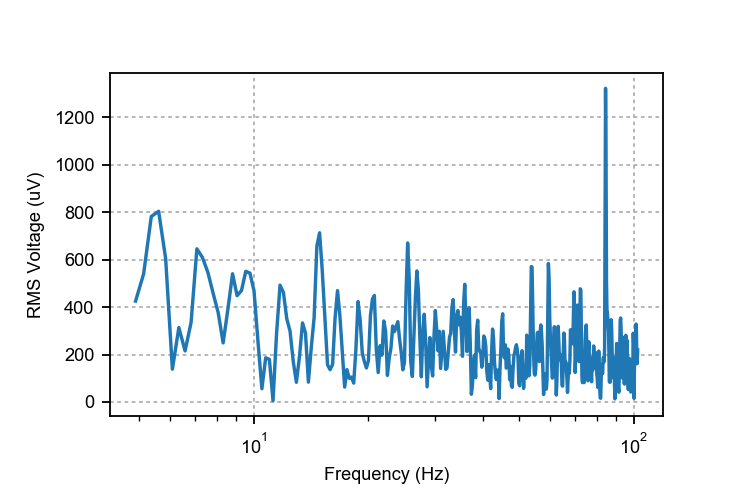

In [32]:
fig, ax = plt.subplots(1,1)
ax.semilogx(fvals, data * 1e6)
#ax.set_ylim([0,500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('RMS Voltage (uV)')
ax.grid(dashes=[2,2])

In [52]:
mdac.ch64.dac_output()

'close'

In [53]:
mdac.ch64.smc('close')

In [54]:
mdac.ch64.awg_sine(85, 1*2*1.414, offset=0, phase=0)

In [55]:
mdac.ch64.attach_trigger()

In [56]:
mdac.ch63.dac_output()

'close'

In [57]:
mdac.ch63.smc('close')

In [119]:
offsets = np.linspace(0, 0.01, 11)
for o in offsets:
    mdac.ch63.voltage(0)
    time.sleep(1)

In [122]:
exp = select_experiment('NiS_QT3', 'summing_box')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(mdac.ch63.voltage)
meas.register_parameter(key1.volt, setpoints=[mdac.ch63.voltage, ])

srcvals = np.linspace(0, 0.1, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        mdac.ch63.voltage(s)
        datasaver.add_result((mdac.ch63.voltage, s), 
                             (key1.volt, key1.volt()))

Starting experimental run with id: 33


In [152]:
exp = select_experiment('NiS_QT3', 'summing_box')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(mdac.ch63.voltage)
meas.register_parameter(lockin1.X, setpoints=[mdac.ch63.voltage, ])
meas.register_parameter(key1.volt, setpoints=[mdac.ch63.voltage, ])

srcvals = np.linspace(-.15, .35, 501)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        mdac.ch63.voltage(s)
#         mdac.ch64.awg_sine(s*100, 1*2*1.414, phase=0)
#         time.sleep(2)
        datasaver.add_result((mdac.ch63.voltage, s), 
                             (lockin1.X, -lockin1.X()),
                             (key1.volt, -key1.volt()))

Starting experimental run with id: 43


In [139]:
2e-3/((.64 + .51)*1e-7*.781)

22267.995323720985

In [73]:
mdac.ch63.voltage(0)

In [154]:
mdac.ch64.awg_off()

In [155]:
mdac.ch64.voltage(0)

In [158]:
mdac.ch08.dac_output()

'close'

In [160]:
mdac.ch08.smc('close')

In [162]:
mdac.ch08.awg_sawtooth(10, 0.1, offset=0, phase=0)

In [163]:
mdac.ch08.attach_trigger()

## Lockin time record
Take lock-in readings over some time range

In [13]:
mdac.ch63.voltage(0)

In [11]:
Npoints = 300
t_wait = 0.1

data = np.empty(Npoints)
ts = np.empty(Npoints)

t0 = time.time()
for i in range(Npoints):
    ts[i] = time.time() - t0
    data[i] = lockin1.X()
    time.sleep(t_wait)



<IPython.core.display.Javascript object>


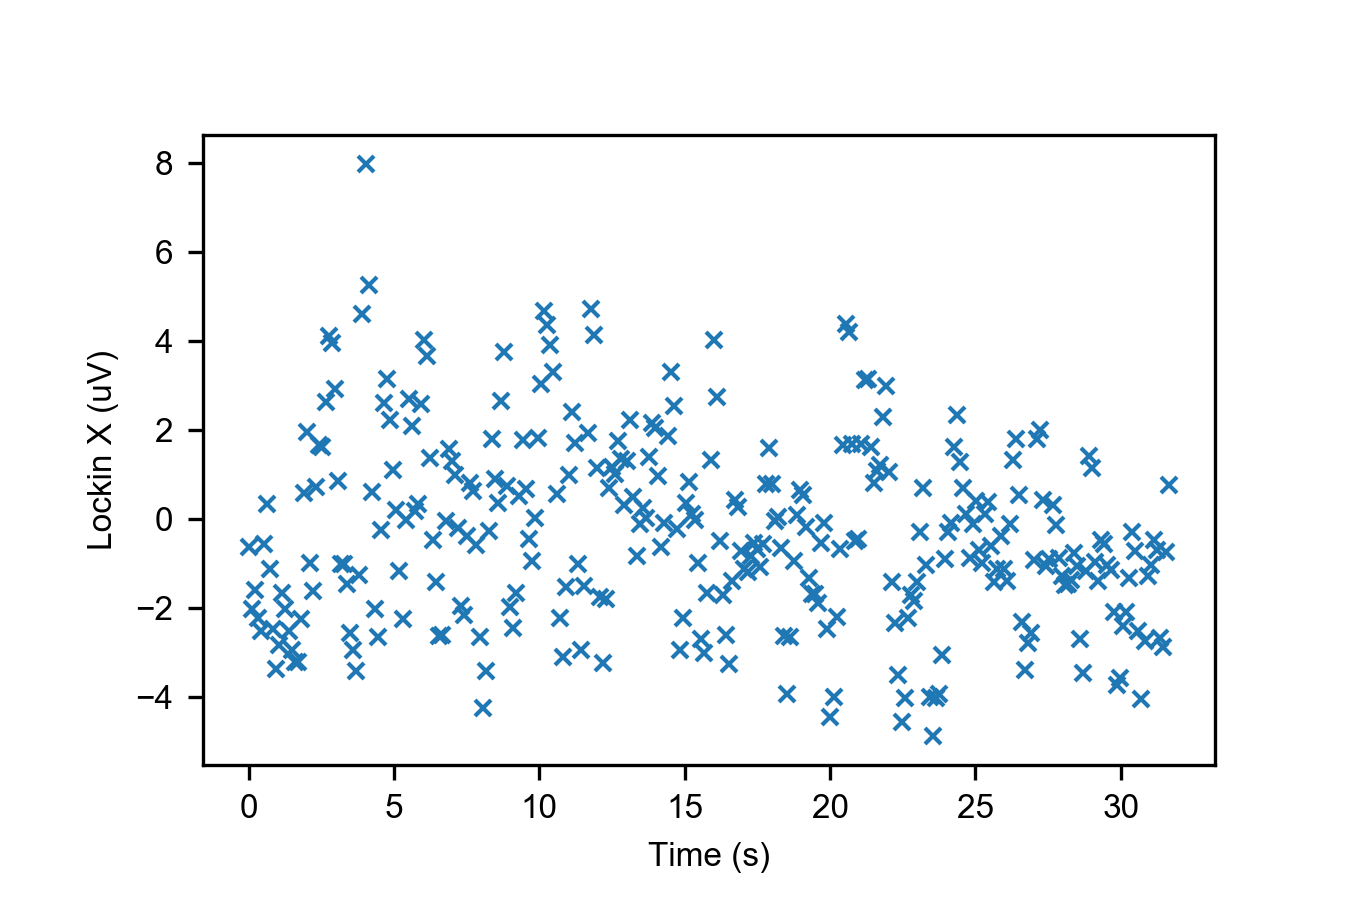

In [12]:
plt.plot(ts, data/1e-6, 'x')
plt.xlabel('Time (s)')
plt.ylabel('Lockin X (uV)')
plt.show()

In [90]:
8e-6/1e7

7.999999999999999e-13

In [91]:
12906*8e-13/10e-6

0.00103248

## Pinchoff curves

In [10]:
dc_setup.DC_didv_bias()

0.0

In [11]:
exp = select_experiment('V0_0113A', 'Device_1')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(dc_setup.DC_didv_bias)
meas.register_parameter(dc_setup.i_measurement, setpoints=[dc_setup.DC_didv_bias, ])



srcvals = np.linspace(-5e-3, 5e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        dc_setup.DC_didv_bias(s)
        datasaver.add_result((dc_setup.DC_didv_bias, s), 
                             (dc_setup.i_measurement, dc_setup.i_measurement()))
                             

Starting experimental run with id: 50


In [69]:
dc_setup.Vbg()

4.999999

In [70]:
exp = select_experiment('V0_0113A', 'Device_1')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(dc_setup.Vbg)
meas.register_parameter(dc_setup.i_measurement, setpoints=[dc_setup.Vbg, ])



srcvals = np.linspace(5, 0, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        dc_setup.Vbg(s)
        datasaver.add_result((dc_setup.Vbg, s), 
                             (dc_setup.i_measurement, dc_setup.i_measurement()))
                             

Starting experimental run with id: 63


In [183]:
dc_setup.DC_didv_bias(0)

In [125]:
exp = select_experiment('V0_0113A', 'Device_1')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(dc_setup.mdac.ch01.voltage)
meas.register_parameter(dc_setup.i_measurement, setpoints=[dc_setup.mdac.ch01.voltage, ])
# meas.register_parameter(dc_setup.g_measurement, setpoints=[dc_setup.mdac.ch01.voltage, ])



srcvals = np.linspace(2.5, 0, 401)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        dc_setup.mdac.ch01.voltage(s)
        datasaver.add_result((dc_setup.mdac.ch01.voltage, s), 
                             (dc_setup.i_measurement, dc_setup.i_measurement()))
#                              (dc_setup.g_measurement, dc_setup.g_measurement()))
                             

Starting experimental run with id: 70


In [182]:
dc_setup.mdac.ch01.voltage()

0.0

In [189]:
dc_setup.mdac.ch56.dac_output('close')
dc_setup.mdac.ch56.smc('open')
dc_setup.mdac.ch56.bus('open')


In [188]:
dc_setup.mdac.ch56.voltage(0)

## Charge noise measurement

### Measurement with scope

In [31]:
for i in range(4):
    station.scope.channels[i].display(False)
station.scope.ch1.display(True)
station.scope.timebase_range(10e-3)
station.scope.timebase_position(5e-3)
station.scope.ch1.range(2)

In [32]:
station.scope.trigger_enabled(True)
station.scope.trigger_edge_source('CHANnel1')
station.scope.trigger_edge_slope('positive')
station.scope.ch2.trigger_level(0.)

In [34]:
station.scope.timeout(50)

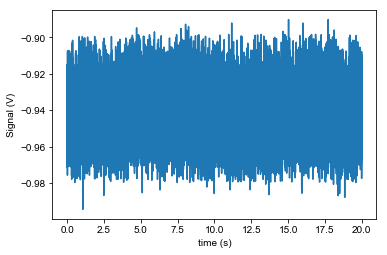

NameError: name 'fft' is not defined

In [35]:
rms_amp = .3
freq = .2
# station.rigol.ch1.ampl(2*np.sqrt(2)*rms_amp)
# station.rigol.ch1.freq(freq)

# nPoints = 200000;
sample_rate = 10000*freq
# time_range = nPoints/sample_rate
time_range = 10/freq
nPoints = int(time_range*sample_rate)


if time_range > 20:
    nPoints = 80000
    sample_rate = 4000
    time_range = nPoints/sample_rate

time_offset = time_range/2    
    
station.scope.timebase_range(time_range)
station.scope.timebase_position(0)
station.scope.acquire_points(nPoints)
# station.scope.acquire_sample_rate(nPoints/station.scope.timebase_range())
station.scope.acquire_sample_rate(sample_rate)

station.scope.ch1.trace.prepare_curvedata()

ts = np.linspace(0, nPoints/station.scope.acquire_sample_rate(), nPoints)
data2 = station.scope.ch1.trace()

%matplotlib inline
plt.plot(ts, data2)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 2*spectrum/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
# plt.semilogx(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (Vrms)')
plt.legend()
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [36]:
import scipy as sc
from scipy.fftpack import fft, rfft

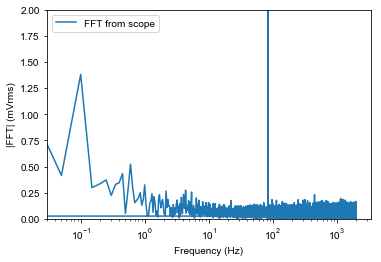

Frequency resolution:  0.049999375


In [45]:
spectrum = abs(fft(data2))
fs = sc.fftpack.fftfreq(data2.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 1000*2*spectrum/(nPoints*np.sqrt(2)), label='FFT from scope')
# plt.semilogx(np.linspace(0,1.5*freq,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0,2])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

### Measurement with lockin

In [11]:
f=400

station.rigol.ch2.impedance(50)
station.rigol.ch2.sin(freq=f, ampl=3, offset=0, phase=0)

In [12]:
dc_setup.DC_didv_bias(5e-3)

In [13]:
capture_variable_name = "X"
station.lockin1.buffer[capture_variable_name]
station.lockin1.buffer.capture_config(capture_variable_name)
trigger_count = 40000
station.lockin1.buffer.set_capture_length_to_fit_samples(trigger_count)
station.lockin1.buffer.start_capture("ONE", "SAMP")
station.lockin1.buffer.wait_until_samples_captured(trigger_count)
station.lockin1.buffer.stop_capture()


NameError: name 'lockin1' is not defined

In [14]:
data = station.lockin1.buffer.get_capture_data(trigger_count)
data = data['X']

In [15]:
ts = np.linspace(0,trigger_count/f, trigger_count)

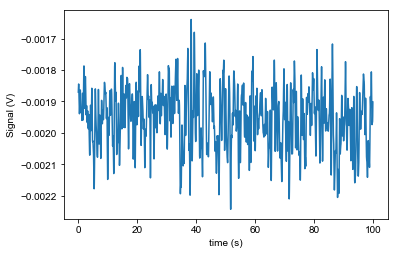

In [16]:
%matplotlib inline
plt.plot(ts, data)
plt.xlabel('time (s)')
plt.ylabel('Signal (V)')
plt.show()

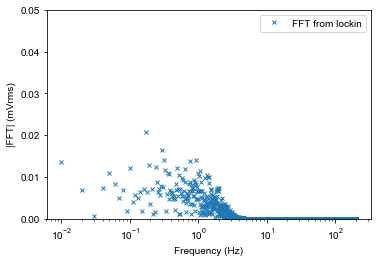

Frequency resolution:  0.00999975


In [21]:
spectrum = abs(fft(data))
fs = sc.fftpack.fftfreq(data.size, ts[1]-ts[0])

%matplotlib inline
plt.semilogx(fs, 1000*2*spectrum/(trigger_count*np.sqrt(2)), 'x', label='FFT from lockin')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.05])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

### Setup scope measurement in a class

In [10]:
#Setup Keysight MSOS254A scope for taking time traces for FFTs of source-drain current
def setup_scope_FFT(scope):
    for i in range(4):
        scope.channels[i].display(False)
    scope.ch1.display(True)
    scope.ch1.range(2)
    
    scope.trigger_enabled(True)
    scope.trigger_edge_source('CHANnel1')
    scope.trigger_edge_slope('positive')
    scope.ch1.trigger_level(0.)

    nPoints = 80000
    sample_rate = 4000
    time_range = nPoints/sample_rate

    time_offset = time_range/2    

    scope.timebase_range(time_range)
    scope.timebase_position(0)
    scope.acquire_points(nPoints)
    scope.acquire_sample_rate(sample_rate)

    scope.ch1.trace.prepare_curvedata()
    
    scope.timeout(50)
    
    return nPoints
    
#Virtual instrument to take FFTs from different instruments using qcodes 
#parameters so they can be saved with standard methods
class Noise_spec(Instrument):
    
    def __init__(self, name, scope, **kw):
        super().__init__(name, **kw)
        
        self.scope = scope        
        
#         self.lockin = lockin
        
        self.nPoints = setup_scope_FFT(self.scope)
        
        self.sample_rate = scope.acquire_sample_rate()
        
        #self.scope_FFT_freqs = np.empty(self.nPoints(), dtype=float)
    
        self.add_parameter('Scope_FFT', get_cmd=self._get_scope_FFT, set_cmd=None)
        
        self.add_parameter('Scope_average_idx', get_cmd=None, set_cmd=None, initial_value=1)
        
        self.add_parameter('Scope_FFT_freqs', get_cmd=self._get_scope_FFT_freqs, set_cmd=None)
        
        self.add_parameter('Scope_trace', get_cmd=self._get_scope_trace, set_cmd=None)
        
#         self.add_parameter('lockin_FFT', get_cmd=self._get_lockin_FFT, set_cmd=None)
        
#         self.add_parameter('lockin_average_idx', get_cmd=None, set_cmd=None, initial_value=1)
        
#         self.add_parameter('lockin_FFT_freqs', get_cmd=self._get_lockin_FFT_freqs, set_cmd=None)
        
#         self.add_parameter('lockin_nPoints', get_cmd=None, set_cmd=None, initial_value=1000)
        
#         self.add_parameter('lockin_sample_rate', get_cmd=self._get_lockin_sample_rate, set_cmd=self._set_lockin_sample_rate)

    
    def _get_scope_FFT(self):
#         ts = np.linspace(0, self.nPoints()/self.scope.acquire_sample_rate(), self.nPoints())
        data = self.scope.ch1.trace()

        spectrum = abs(fft(data))
#         fs = sc.fftpack.fftfreq(data.size, ts[1]-ts[0])
        return spectrum
    
    def _get_scope_FFT_freqs(self):
        fs = sc.fftpack.fftfreq(self.nPoints, 1/self.sample_rate)
        return fs
    
    def _get_scope_trace(self):
        data = self.scope.ch1.trace()
        return data
    
    

In [14]:
noise_spec = create_inst(Noise_spec, 'noise_spec', scope=station.scope, force_new_instance=True)

Instrument noise_spec already exists.


In [95]:
station.scope.timebase_position(0)
station.scope.ch1.range(4)

In [105]:
data2 = noise_spec.Scope_trace()
ts = np.linspace(0, noise_spec.nPoints/noise_spec.sample_rate, noise_spec.nPoints)

In [24]:
from scipy import signal

<IPython.core.display.Javascript object>


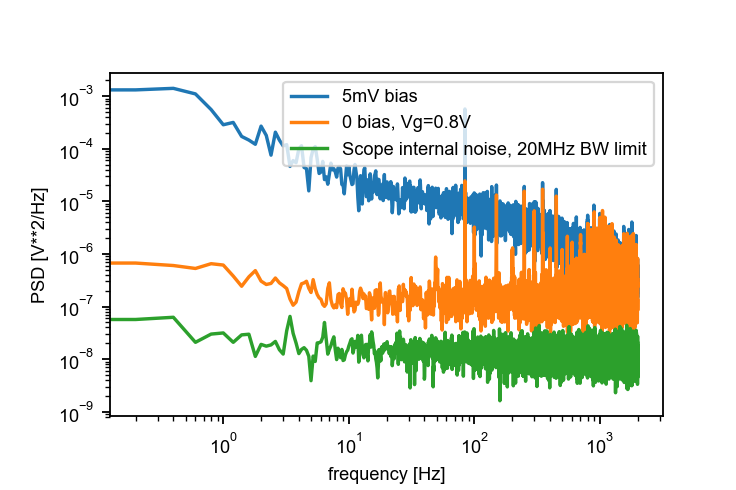

In [108]:
f, Pxx_den = signal.welch(data, noise_spec.sample_rate, nperseg=20000)
f2, Pxx_den2 = signal.welch(data2, noise_spec.sample_rate, nperseg=20000)
f3, Pxx_den3 = signal.welch(data3, noise_spec.sample_rate, nperseg=20000)
plt.loglog(f, Pxx_den, label='5mV bias')
plt.loglog(f2, Pxx_den2, label='0 bias, Vg=0.8V')
plt.loglog(f3, Pxx_den3, label='Scope internal noise, 20MHz BW limit')
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


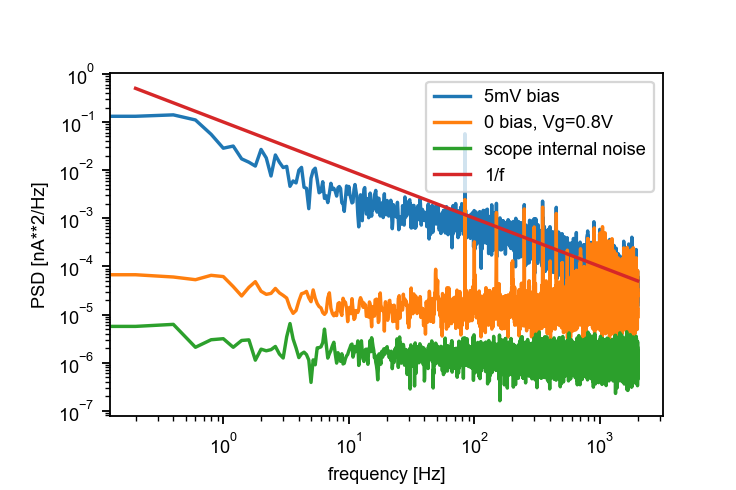

C:\ProgramData\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [113]:
f, Pxx_den = signal.welch(data, noise_spec.sample_rate, nperseg=20000)
f2, Pxx_den2 = signal.welch(data2, noise_spec.sample_rate, nperseg=20000)
plt.loglog(f, Pxx_den*1e-16/1e-18, label='5mV bias')
plt.loglog(f2, Pxx_den2*1e-16/1e-18, label='0 bias, Vg=0.8V')
plt.loglog(f3, Pxx_den3*1e-16/1e-18, label='scope internal noise')
plt.loglog(f3, 0.1/f3, label='1/f')
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [nA**2/Hz]')
plt.legend()
plt.show()

In [104]:
dc_setup.DC_didv_bias(0)

<IPython.core.display.Javascript object>


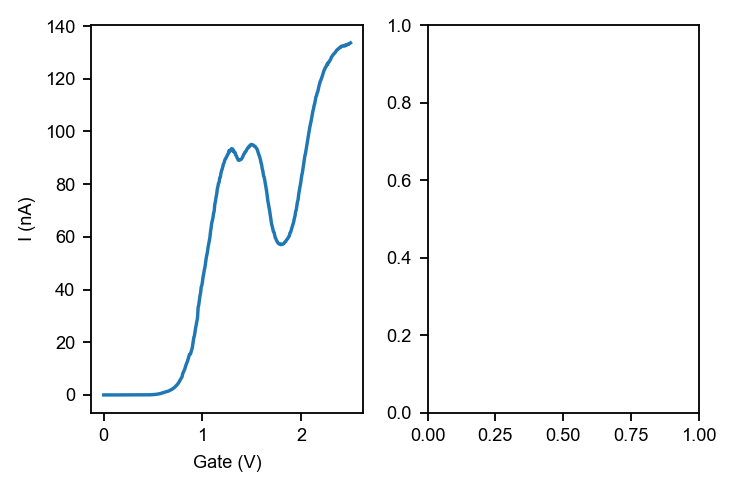

In [130]:
dv1 = qc.load_by_id(69)
bg_fw = np.array(dv1.get_data("mdac_chan1_voltage"))[:,0] 
i_fw = np.array(dv1.get_values('dc_setup_i_measurement'))[:,0]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(bg_fw, i_fw*1e9)
#ax1.plot(bg_bw, i_bw*1e9)
ax1.set_xlabel('Gate (V)')
ax1.set_ylabel('I (nA)')

#ax2.plot(bg_fw, g_fw)
#ax2.plot(bg_bw, g_bw)
#ax2.set_xlabel('backgate (V)')
#ax2.set_ylabel(r'g (2e$^2$/h)')
#ax2.set_xlim([-4, 0])
#ax2.set_ylim([0,4])

# fig.suptitle(ds_title("bw_" + str(dv1.run_id) + "_fw_" + str(dv2.run_id)), size='x-small')
fig.tight_layout()

In [136]:
import pandas as pd

<IPython.core.display.Javascript object>


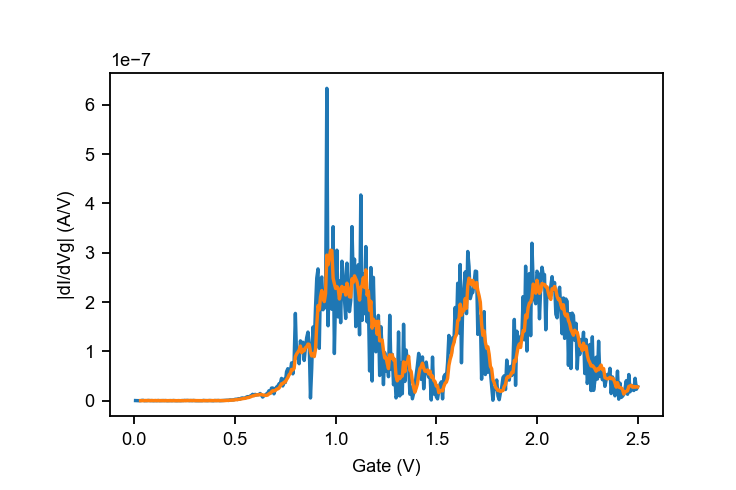

In [174]:
deriv = abs(np.diff(i_fw)/np.diff(bg_fw))

df = pd.DataFrame(deriv)
deriv_smooth = df.rolling(8).mean()
deriv_smooth = np.array(smooth)

plt.plot(bg_fw[1::], deriv)
plt.plot(bg_fw[1::], deriv_smooth)
plt.xlabel('Gate (V)')
plt.ylabel('|dI/dVg| (A/V)')
plt.show()

In [176]:
dIdVg = deriv_smooth[np.argmin(abs(bg_fw - 0.8))]

9.49034486399997e-08


In [177]:
from scipy import integrate

In [181]:
f_lower_idx = np.argmin(abs(f - 1))
f_lower = f[f_lower_idx] #set lower limit of integration to ~1Hz
f_upper_idx = np.argmin(abs(f - 49))
f_upper = f[f_upper_idx] #set upper limit of integration to ~49Hz

arg = (Pxx_den - Pxx_den2)*1e-16
PSD_int = integrate.cumtrapz(arg, f)[f_upper_idx] - integrate.cumtrapz(arg, f)[f_lower_idx]

V_eg = np.sqrt(2*PSD_int)/dIdVg
print('V_eg = ' + str(V_eg) + ' V')

V_eg = 0.005226931361620454 V


In [44]:
noise_spec.nPoints

80000

In [ ]:
#Start user settings
idxvals = np.linspace(1, 10, 10)
#End user settings

t0 = time.time()
exp = select_experiment('Code_testing', 'Open_circuit')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(noise_spec.Scope_average_idx)
meas.register_parameter(noise_spec.Scope_FFT_freqs)
meas.register_parameter(noise_spec.Scope_FFT, setpoints=[noise_spec.Scope_average_idx, noise_spec.Scope_FFT_freqs ])



with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for idx in idxvals:
        noise_spec.Scope_average_idx(idx)
        datasaver.add_result((noise_spec.Scope_average_idx, idx), 
                             (noise_spec.Scope_FFT_freqs, noise_spec.Scope_FFT_freqs()),
                             (noise_spec.Scope_FFT, noise_spec.Scope_FFT()))
        
print('Measurement time = ', time.time()-t0)

<IPython.core.display.Javascript object>


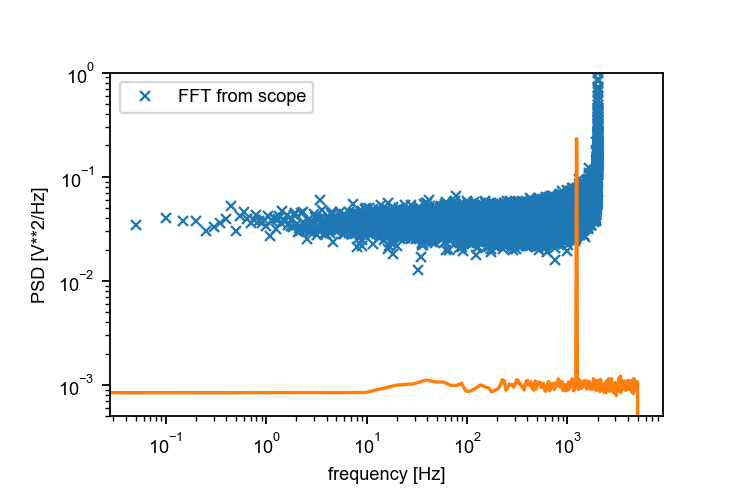

Frequency resolution:  0.049999999999954525


In [40]:
dv = qc.load_by_id(55)
fs = np.array(dv.get_data("noise_spec_Scope_FFT_freqs"))[:,0] 
idx = np.array(dv.get_data("noise_spec_Scope_average_idx"))[:,0] 
spectrum = np.array(dv.get_data("noise_spec_Scope_FFT"))[:,0] 

fs = np.unique(fs)
idx = np.unique(idx)
spectrum = spectrum.reshape(idx.size, fs.size)

average = np.empty(len(fs))
for i in range(len(idx)):
    average += spectrum[i,:]
average = average/len(idx)

nPoints = noise_spec.nPoints
plt.semilogx(fs, 1000*2*average/(nPoints*np.sqrt(2)), 'x', label='FFT from scope')
#plt.semilogx(np.linspace(0,1.5*f,101), rms_amp*np.ones(101), label='Rigol RMS amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('|FFT| (mVrms)')
plt.legend()
plt.ylim([0, 0.5])
plt.show()

print('Frequency resolution: ', fs[1] - fs[0])

In [33]:
station.scope.channels.display()

c:\users\administrator\onedrive\bf5\code\qcodes\qcodes\instrument\parameter.py:1233: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


(True, False, False, False)

In [61]:
from scipy import signal

In [62]:
fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

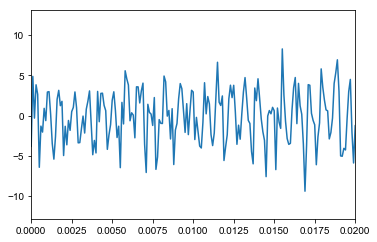

In [70]:
%matplotlib inline
plt.plot(time, x)
plt.xlim([0,0.02])
plt.show()

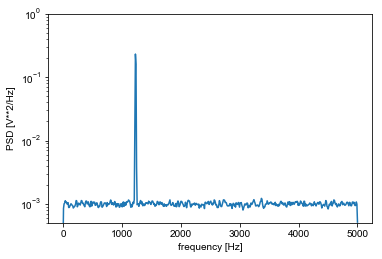

In [64]:
%matplotlib inline
f, Pxx_den = signal.welch(x, fs, nperseg=1024)
plt.semilogy(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Bias vs gate

In [17]:
ivvi.dac1(0)

In [23]:
exp = select_experiment('V0_0113A', 'Device_3_5_12')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac3)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])

lockin1.amplitude(0.1)

srcvals = np.linspace(-2.5, -2.7, 11)
bias_values = np.linspace(-.6e-3, .6e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in srcvals:
        ivvi_setup.dac3(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi_setup.dac3, s1),
                                 (ivvi_setup.dac1, s2), 
                                 (ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 (ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 (ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 56


KeyboardInterrupt: 

## Plunger vs cutter scans

In [20]:
ivvi.set_dacs_zero()

In [132]:
ami.spherical([1.5, 2, 90])

In [17]:
lockin1.time_constant(0.1)
lockin2.time_constant(0.1)
lockin2.time_constant(0.1)
lockin1.input_range(300e-3)
lockin2.input_range(300e-3)
lockin3.input_range(300e-3)
lockin1.sensitivity(50e-3)

In [44]:
ami.spherical()

[1.9900022529132977, 1.9999977798489441, 90.0]

In [18]:
ivvi_setup.dac3(-6.5)

In [19]:
exp = select_experiment('V0_0113A', 'Device_48')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac7)
meas.register_parameter(ivvi.dac6)
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi.dac4])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi.dac7, ivvi.dac6])


lockin1.amplitude(0.15)

cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 600, 401)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            time.sleep(0.1)
            
            datasaver.add_result((ivvi.dac7, p),
                                 (ivvi.dac6, c), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),                                 
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))

Starting experimental run with id: 537


In [42]:
ivvi_setup.dac3(-7)

In [43]:
exp = select_experiment('V0_0113A', 'Device_48')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac7)
meas.register_parameter(ivvi.dac6)
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi.dac4])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi.dac7, ivvi.dac6])


lockin1.amplitude(0.15)

cuttervals = np.linspace(0, 400, 101)
plungervals = np.linspace(-1200, 600, 401)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for c in cuttervals:
        ivvi.dac6(c)
        for p in plungervals:
            ivvi.dac7(p)
            time.sleep(0.1)
            
            datasaver.add_result((ivvi.dac7, p),
                                 (ivvi.dac6, c), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),                                 
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))

Starting experimental run with id: 505


## Bias vs side plunger

In [12]:
ivvi.dac4(275)


In [109]:
exp = select_experiment('V0_0113A', 'Device_5')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac7)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac7, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi.dac7, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi.dac7, ivvi_setup.dac1])

lockin1.amplitude(0.1)

plungervals = np.linspace(-500, 100, 401)
bias_values = np.linspace(-.5e-3, .5e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in plungervals:
        ivvi.dac7(s1)
        t0 = time.time()
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi.dac7, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))
        t1 = time.time()
        print('Inner loop time = ' + str(t1 - t0) + 's')

Starting experimental run with id: 188
Inner loop time = 13.694518327713013s
Inner loop time = 13.861659288406372s
Inner loop time = 13.741578578948975s
Inner loop time = 13.786577939987183s


KeyboardInterrupt: 

In [23]:
ivvi.dac4(500)

In [24]:
exp = select_experiment('V0_0113A', 'Device_3')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac5)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])

lockin1.amplitude(0.1)

plungervals = np.linspace(-1000, -400, 301)
bias_values = np.linspace(-.5e-3, .5e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in plungervals:
        ivvi.dac5(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi.dac5, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 100


In [17]:
ivvi.dac4(530)

In [18]:
exp = select_experiment('V0_0113A', 'Device_3')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac5)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])

lockin1.amplitude(0.1)

plungervals = np.linspace(-1000, 0, 501)
bias_values = np.linspace(-.5e-3, .5e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in plungervals:
        ivvi.dac5(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi.dac5, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 97


In [19]:
ivvi.dac4(617)

In [20]:
exp = select_experiment('V0_0113A', 'Device_3')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac5)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])

lockin1.amplitude(0.1)

plungervals = np.linspace(-1000, 0, 501)
bias_values = np.linspace(-.5e-3, .5e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in plungervals:
        ivvi.dac5(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi.dac5, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 98


In [21]:
ivvi.dac4(235)

In [22]:
exp = select_experiment('V0_0113A', 'Device_3')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac5)
meas.register_parameter(ivvi_setup.dac1)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])

lockin1.amplitude(0.1)

plungervals = np.linspace(-250, 500, 501)
bias_values = np.linspace(-.5e-3, .5e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in plungervals:
        ivvi.dac5(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ivvi.dac5, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 99


KeyboardInterrupt: 

## Bias vs theta scans

In [102]:
ivvi_setup.dac3(-3.8)

In [93]:
ami.spherical([0.3,0,90])

In [99]:
ami.z_measured()

-0.30001

In [103]:
exp = select_experiment('V0_0113A', 'Device_44_48_12')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(yoko.voltage)
meas.register_parameter(ami.theta)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.theta, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.theta, yoko.voltage])

lockin1.amplitude(0.1)

theta_vals = np.linspace(180, 0, 90)
bias_values = np.linspace(-0.5e-3, 0.5e-3, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in theta_vals:
        ami.theta(s1)
        yoko.voltage(biasvals[0])
        time.sleep(2)
        for s2 in bias_values:
            yoko.voltage(s2)
            datasaver.add_result((ami.theta, s1),
                                 (yoko.voltage, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 255


KeyboardInterrupt: 

In [ ]:
ivvi_setup.dac3(-7.9)

In [ ]:
exp = select_experiment('V0_0113A', 'Device_44_48_12')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(yoko.voltage)
meas.register_parameter(ami.theta)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.theta, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.theta, yoko.voltage])

lockin1.amplitude(0.1)

theta_vals = np.linspace(0, 180, 90)
bias_values = np.linspace(-0.5e-3, 0.5e-3, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in theta_vals:
        ami.theta(s1)
        yoko.voltage(biasvals[0])
        time.sleep(2)
        for s2 in bias_values:
            yoko.voltage(s2)
            datasaver.add_result((ami.theta, s1),
                                 (yoko.voltage, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

In [97]:
ivvi_setup.dac3(-7)

In [98]:
exp = select_experiment('V0_0113A', 'Device_44_48_12')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(yoko.voltage)
meas.register_parameter(ami.theta)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.theta, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.theta, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.theta, yoko.voltage])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.theta, yoko.voltage])

lockin1.amplitude(0.1)

theta_vals = np.linspace(0, 180, 90)
bias_values = np.linspace(-0.5e-3, 0.5e-3, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in theta_vals:
        ami.theta(s1)
        yoko.voltage(biasvals[0])
        time.sleep(2)
        for s2 in bias_values:
            yoko.voltage(s2)
            datasaver.add_result((ami.theta, s1),
                                 (yoko.voltage, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 253


## Bias vs chemical potential

In [13]:
yoko.range(0.01)
yoko.current_limit(0.001)
yoko.voltage(0)
yoko.on()

In [61]:
ami.spherical([1.5,3,90])

In [11]:
ivvi_setup.dac3(-3.5)
ivvi.dac4(0)
ivvi.dac5(-1000)
ivvi.dac5(240)

In [12]:
def gateslope(pt1, pt2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    
    return m

In [21]:
#Procedure for using smartgate function to sweep chemical potential: Take cutter vs plunger scan (cutter ~ y, 
#plunger ~ x).  Get slope of dot resonance at two points (pt1 & pt2).  Scan bias vs plunger at some fixed cutter 
#voltage to find desired cotunneling regime (e.g. fix x0 and y0).  Input starting and ending plunger values (x1 & x2)
#Function will output corresponding cutter voltages to keep the dot in the same cotunneling regime
def smartgate2(pt1, pt2, x0, y0, x1, x2):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    b1 = -m*x0 + y0
    y1 = x1*m + b1
    y2 = x2*m + b1
    return y1, y2

def smartgate3(pt1, pt2, x0, y0, x1, x2, perp=False):
    m = (pt1[1] - pt2[1])/(pt1[0] - pt2[0])
    b = -m*pt1[0] + pt1[1]
    
    b1 = -m*x0 + y0
    y1 = x1*m + b1
    y2 = x2*m + b1
    
    if perp:
        m_perp = -1/m
        b_perp = y0 + x0/m
        y1 = x1*m_perp + b_perp
        y2 = x2*m_perp +b_perp
    return y1, y2

In [41]:
lockin1.time_constant(0.1)

In [ ]:
pt1 = [-961, 165]
pt2 = [-727, 120]
x0 = -800
y0 = 159
plungerstart = -830
plungerend = -770
perp = True
Npoints = 401

exp = select_experiment('V0_0113A', 'Device_44')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi.dac5, paramtype='array')
meas.register_parameter(yoko.voltage)
#meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi.dac5, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi.dac5, yoko.voltage])
# meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi.dac5, yoko.voltage])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi.dac9, ivvi_setup.dac1])

lockin1.amplitude(0.1)


plungervals = np.linspace(plungerstart, plungerend, Npoints)
# cutterstart = 0
# cutterend = cutterstart + gateslope(pt1, pt2)*(plungerend - plungerstart)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)

bias_values = np.linspace(-.4e-3, .4e-3, 121)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for i in range(len(plungervals)):
        ivvi.dac5(plungervals[i])
        ivvi.dac4(cuttervals[i])
        for s2 in bias_values:
            yoko.voltage(s2)
            time.sleep(0.2)
            datasaver.add_result((ivvi.dac5, plungervals[i]),
                                 (yoko.voltage, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

### Hardware ramp chemical potential sweep

In [35]:
lockin2.time_constant(0.1)

In [37]:
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-1100, 105]
pt2 = [-620, 0]
x0 = -550
y0 = 50
plungerstart = -950
plungerend = -350
perp = True
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac7)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac7(plungervals[i])
        ivvi.dac6(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac7, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 501
Total measurement time: 50.52196811834971min


In [38]:
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-1100, 105]
pt2 = [-620, 0]
x0 = -750
y0 = 95
plungerstart = -950
plungerend = -350
perp = True
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac7)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac7(plungervals[i])
        ivvi.dac6(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac7, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 502
Total measurement time: 50.825902664661406min


In [55]:
ami_y.ramp_to(0)

In [56]:
ivvi_setup.dac3(-6.5)

In [53]:
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-1100, 105]
pt2 = [-620, 0]
x0 = -790
y0 = 50
plungerstart = -1200
plungerend = -500
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac7)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac7))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac7(plungervals[i])
        ivvi.dac6(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac7, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 506


KeyboardInterrupt: 

In [50]:
pt1 = [-1100, 105]
pt2 = [-620, 0]
x0 = -790
y0 = 50
plungerstart = -1200
plungerend = -500
perp = False
plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

In [130]:
ami.spherical([1.5,2,90])

In [69]:
lockin1.time_constant(0.03)
lockin1.frequency(113)

In [131]:
ivvi_setup.dac3(-6.5)

In [149]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 479
Total measurement time: 50.586571077505745min


In [150]:
ami.spherical([1.99,2,90])

In [151]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 480
Total measurement time: 50.647199340661366min


In [154]:
ami.spherical([1.5,2,90])
ivvi_setup.dac3(-6.6)

In [155]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 482
Total measurement time: 50.58803215026855min


In [156]:
ami.spherical([1.99,2,90])

In [157]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 483
Total measurement time: 50.64590185880661min


In [158]:
ami.spherical([1.5,2,90])
ivvi_setup.dac3(-6.7)

In [159]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 484
Total measurement time: 50.64167077143987min


In [160]:
ami.spherical([1.99,2,90])

In [161]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 485
Total measurement time: 50.650788164138795min


In [16]:
ami.spherical([1.5,2,90])
ivvi_setup.dac3(-6.8)

In [21]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 486
Total measurement time: 50.626519219080606min


In [22]:
ami.spherical([1.99,2,90])

In [23]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 487
Total measurement time: 50.64417238632838min


In [24]:
ami.spherical([1.5,2,90])
ivvi_setup.dac3(-6.9)

In [25]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 488
Total measurement time: 50.6468722820282min


In [26]:
ami.spherical([1.99,2,90])

In [27]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 489
Total measurement time: 50.64464604457219min


In [28]:
ami.spherical([1.5,2,90])
ivvi_setup.dac3(-7)

In [29]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 490
Total measurement time: 50.64062402248383min


In [30]:
ami.spherical([1.99,2,90])

In [31]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)
lockin1.amplitude(0.15)

pt1 = [-752, 255]
pt2 = [-124, 118]
x0 = -124
y0 = 127
plungerstart = -1200
plungerend = 400
perp = False
Npoints = 401


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi.dac9)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi.dac9))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


plungervals = np.linspace(plungerstart, plungerend, Npoints)
cutterstart, cutterend = smartgate3(pt1, pt2, x0, y0, plungerstart, plungerend, perp)
cuttervals = np.linspace(cutterstart, cutterend, len(plungervals))

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for i in range(len(plungervals)):
        ivvi.dac9(plungervals[i])
        ivvi.dac8(cuttervals[i])
#         if i%5==0:
#             print(str(plungervals[i]) + ',' + str(cuttervals[i]))
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi.dac9, plungervals[i]),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 491
Total measurement time: 50.64555949370067min


#### Frequency optimization

In [43]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)


exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(lockin1.frequency)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, lockin1.frequency))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, lockin1.frequency))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, lockin1.frequency))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


fvals = np.linspace(93, 133, 44)

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for f in fvals:
        lockin1.frequency(f)
    
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (lockin1.frequency, f),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 365
Total measurement time: 5.683491841952006min


## Bias vs Br sweep

In [124]:
ivvi.dac5(-800)
ivvi.dac4(235)

In [39]:
(-860, 106.423076923)

3495

In [125]:
ami.spherical([1.99,2,90])

In [88]:
exp = select_experiment('V0_0113A', 'DEV_5')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(ivvi_setup.dac1)
meas.register_parameter(ami.field)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.field, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.field, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.field, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.field, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.field, ivvi_setup.dac1])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.field, ivvi_setup.dac1])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.field, ivvi_setup.dac1])

lockin1.amplitude(0.1)

Br_vals = np.linspace(1.99, 0, 200)
bias_values = np.linspace(-.4e-3, .4e-3, 121)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in Br_vals:
        ami.field(s1)
        for s2 in bias_values:
            ivvi_setup.dac1(s2)
            datasaver.add_result((ami.field, s1),
                                 (ivvi_setup.dac1, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 #(ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()))#,
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))
                                 #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 178


### Hardware sweep variety

In [ ]:
yoko.range(0.01)
yoko.current_limit(0.001)
yoko.voltage(0)
yoko.on()

In [126]:
ami.spherical([1.99,2,90])

In [152]:
ivvi.dac9(-1200)
ivvi.dac8(362)

In [153]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)



exp = select_experiment('V0_0113A', 'DEV_1_48_12')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ami.field)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ami.field))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ami.field))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ami.field))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())


Bvals = np.linspace(1.99, 0, 200)

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for B in Bvals:
        ami.field(B)
    
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ami.field, B),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 481
Total measurement time: 120.04468477567038min


## Bias vs phi sweeps

In [101]:
ami.spherical([0.6,17,0])

In [102]:
exp = select_experiment('V0_0112A', 'DEV_30_33_35')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(ivvi_setup.dac5)
meas.register_parameter(ami.phi)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.phi, ivvi_setup.dac5])

lockin1.amplitude(0.1)

phi_vals = np.linspace(0, 180, 91)
bias_values = np.linspace(-.6e-3, .6e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in phi_vals:
        ami.phi(s1)
        for s2 in bias_values:
            ivvi_setup.dac5(s2)
            datasaver.add_result((ami.phi, s1),
                                 (ivvi_setup.dac5, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 315


In [103]:
ami.spherical([0.6,35,180])

In [104]:
exp = select_experiment('V0_0112A', 'DEV_30_33_35')

meas = Measurement(exp=exp)
meas.write_period = 1
#meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(ivvi_setup.dac5)
meas.register_parameter(ami.phi)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
#meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ami.phi, ivvi_setup.dac5])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ami.phi, ivvi_setup.dac5])

lockin1.amplitude(0.1)

phi_vals = np.linspace(180, 0, 91)
bias_values = np.linspace(-.6e-3, .6e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in phi_vals:
        ami.phi(s1)
        for s2 in bias_values:
            ivvi_setup.dac5(s2)
            datasaver.add_result((ami.phi, s1),
                                 (ivvi_setup.dac5, s2), 
                                 #(ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                                 #(ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                                 #(ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

Starting experimental run with id: 316


In [105]:
ami.field(0)

In [206]:
ivvi_setup.dac4(0)

## I bias sweep

In [205]:
exp = select_experiment('V0_0112A', 'DEV_29_NC')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.v1_measurement, setpoints=[ivvi_setup.dac4, ])
meas.register_parameter(ivvi_setup.v2_measurement, setpoints=[ivvi_setup.dac4, ])
meas.register_parameter(ivvi_setup.r_ac1_measurement, setpoints=[ivvi_setup.dac4, ])
meas.register_parameter(ivvi_setup.r_ac2_measurement, setpoints=[ivvi_setup.dac4, ])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac6, ])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac6, ])



srcvals = np.linspace(-25e-9, 25e-9, 301)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac4(s)
        time.sleep(0.2)
        datasaver.add_result((ivvi_setup.dac4, s), 
                             (ivvi_setup.v1_measurement, ivvi_setup.v1_measurement()),
                             (ivvi_setup.v2_measurement, ivvi_setup.v2_measurement()),
                             (ivvi_setup.r_ac1_measurement, ivvi_setup.r_ac1_measurement()),
                             (ivvi_setup.r_ac2_measurement, ivvi_setup.r_ac2_measurement()))

Starting experimental run with id: 354


## I bias vs gate

In [165]:
exp = select_experiment('V0_0112A', 'DEV_37_45')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ivvi_setup.dac6)
meas.register_parameter(ivvi_setup.v1_measurement, setpoints=[ivvi_setup.dac4, ivvi_setup.dac6])
meas.register_parameter(ivvi_setup.v2_measurement, setpoints=[ivvi_setup.dac4, ivvi_setup.dac6])
meas.register_parameter(ivvi_setup.r_ac1_measurement, setpoints=[ivvi_setup.dac4, ivvi_setup.dac6])
meas.register_parameter(ivvi_setup.r_ac2_measurement, setpoints=[ivvi_setup.dac4, ivvi_setup.dac6])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac6, ])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac6, ])



srcvals = np.linspace(-100e-9, 100e-9, 601)
gatevals = np.linspace(10,0,101)

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in gatevals:
        ivvi_setup.dac6(s)
        for s2 in srcvals:
            ivvi_setup.dac4(s2)
            #time.sleep(0.2)
            datasaver.add_result((ivvi_setup.dac4, s2), 
                                 (ivvi_setup.dac6, s),
                                 (ivvi_setup.v1_measurement, ivvi_setup.v1_measurement()),
                                 (ivvi_setup.v2_measurement, ivvi_setup.v2_measurement()),
                                 (ivvi_setup.r_ac1_measurement, ivvi_setup.r_ac1_measurement()),
                                 (ivvi_setup.r_ac2_measurement, ivvi_setup.r_ac2_measurement()))

Starting experimental run with id: 338


KeyboardInterrupt: 

In [217]:
ivvi_setup.dac4(0)

In [211]:
ami_z.pause()

## Ibias vs theta scan

In [223]:
ami_x.pause()
ami_y.pause()
ami_z.pause()

In [224]:
ami.spherical([0,41,90])

KeyboardInterrupt: 

In [220]:
exp = select_experiment('V0_0112A', 'DEV_31_34')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ami.theta)
meas.register_parameter(ivvi_setup.v1_measurement, setpoints=[ivvi_setup.dac4, ami.theta])
meas.register_parameter(ivvi_setup.v2_measurement, setpoints=[ivvi_setup.dac4, ami.theta])
# meas.register_parameter(ivvi_setup.r_ac1_measurement, setpoints=[ivvi_setup.dac4, ami.theta])
# meas.register_parameter(ivvi_setup.r_ac2_measurement, setpoints=[ivvi_setup.dac4, ami.theta])

lockin1.amplitude(0.1)



theta_vals = np.linspace(0, 180, 60)
bias_values = np.linspace(-50e-9, 50e-9, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s1 in theta_vals:
        ami.theta(s1)
        for s2 in bias_values:
            ivvi_setup.dac4(s2)
            datasaver.add_result((ami.theta, s1),
                                 (ivvi_setup.dac4, s2), 
                                 (ivvi_setup.v1_measurement, ivvi_setup.v1_measurement()),
                                 (ivvi_setup.v2_measurement, ivvi_setup.v2_measurement()))
#                                  (ivvi_setup.r_ac1_measurement, ivvi_setup.r_ac1_measurement()),
#                                  (ivvi_setup.r_ac2_measurement, ivvi_setup.r_ac2_measurement()))

Starting experimental run with id: 358


KeyboardInterrupt: 

## I bias vs field magnitude

In [231]:
ami_x.pause()
ami_y.pause()
ami_z.pause()
ami.spherical([0,41,90])
ivvi.set_dacs_zero()

In [230]:
exp = select_experiment('V0_0112A', 'DEV_31_34')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac4)
meas.register_parameter(ami.field)
meas.register_parameter(ivvi_setup.v1_measurement, setpoints=[ivvi_setup.dac4, ami.field])
meas.register_parameter(ivvi_setup.v2_measurement, setpoints=[ivvi_setup.dac4, ami.field])
#meas.register_parameter(ivvi_setup.r_ac1_measurement, setpoints=[ivvi_setup.dac4, ami.field])
#meas.register_parameter(ivvi_setup.r_ac2_measurement, setpoints=[ivvi_setup.dac4, ami.field])

lockin1.amplitude(0.1)

Br_vals_fw = np.linspace(0, 1, 41)
Br_vals_bw = np.linspace(0, 1, 41)
bias_values = np.linspace(-.5e-7, .5e-7, 101)
bg_vals = [10]

for s0 in bg_vals: 
    if s0%2 == 0: 
        with meas.run() as datasaver:
            datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                        min_wait=0, min_count=1)

            for s1 in Br_vals_fw:
                ami.field(s1)
                for s2 in bias_values:
                    ivvi_setup.dac4(s2)
                    datasaver.add_result((ami.field, s1),
                                         (ivvi_setup.dac4, s2), 
                                         (ivvi_setup.v1_measurement, ivvi_setup.v1_measurement()),
                                         (ivvi_setup.v2_measurement, ivvi_setup.v2_measurement()))#,
                                         #(ivvi_setup.r_ac1_measurement, ivvi_setup.r_ac1_measurement()),
                                         #(ivvi_setup.r_ac2_measurement, ivvi_setup.r_ac2_measurement()))
    if s0%2 == 1:
        with meas.run() as datasaver:
            datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                        min_wait=0, min_count=1)

            for s1 in Br_vals_bw:
                ami.field(s1)
                for s2 in bias_values:
                    ivvi_setup.dac4(s2)
                    datasaver.add_result((ami.field, s1),
                                         (ivvi_setup.dac4, s2), 
                                         (ivvi_setup.v1_measurement, ivvi_setup.v1_measurement()),
                                         (ivvi_setup.v2_measurement, ivvi_setup.v2_measurement()))#,
                                         #(ivvi_setup.r_ac1_measurement, ivvi_setup.r_ac1_measurement()),
                                         #(ivvi_setup.r_ac2_measurement, ivvi_setup.r_ac2_measurement()))

Starting experimental run with id: 361


In [ ]:
exp = select_experiment('V0_0112A', 'DEV_2_3_4')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac5)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac5, ])


srcvals = np.linspace(-10e-3, 10e-3, 101)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac5(s)
        datasaver.add_result((ivvi_setup.dac5, s), 
                             (ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                             (ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                             (ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                             (ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                             (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                             (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                             (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

In [ ]:
ivvi_setup = create_inst(IVVISetup, 'ivvi_setup', ivvi=ivvi, force_new_instance=True)
ivvi_setup.voltage_multiplier(100e-9)

ivvi_setup.add_parameter('v_measurement', parameter_class=ConversionParameter, unit='V',
                         src_param=key2.volt, get_conv=lambda x: x/200)
ivvi_setup.add_parameter('i_measurement', parameter_class=ConversionParameter, unit='A',
                         src_param=key1.volt, get_conv=lambda x: x / ivvi_setup.M1b_gain())

In [ ]:
exp = select_experiment('DEV43 Isw test', 'V0_0112A')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac2)
meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac2, ])
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac2, ])


srcvals = np.linspace(-30e-9, 30e-9, 151)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac2(s)
        datasaver.add_result((ivvi_setup.dac2, s), 
                             (ivvi_setup.v_measurement, ivvi_setup.v_measurement()),
                             (ivvi_setup.i_measurement, ivvi_setup.i_measurement()))

In [ ]:
ivvi.dac2(100)

In [ ]:
key2.volt()

In [232]:
ivvi.set_dacs_zero()

In [ ]:
from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600

In [ ]:
keithley = create_inst(Keithley_2600, "keithley", "USB0::0x05E6::0x2614::4345885::INSTR")

In [ ]:
keithley.smua.res()

In [ ]:
exp = select_experiment('V0_0112A', 'Cooldown')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac1)
meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac1, ])
meas.register_parameter(ivvi_setup.i_measurement, setpoints=[ivvi_setup.dac1, ])


srcvals = np.linspace(0, 0, 3e5)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    i = 0 
    for s in srcvals:
        i += 1
#         ivvi_setup.dac1(s)
        time.sleep(1)
        datasaver.add_result((ivvi_setup.dac1, i), 
                             (ivvi_setup.v_measurement, keithley.smua.res()),
                             (ivvi_setup.i_measurement, ivvi_setup.i_measurement()))

In [ ]:
Br = 2
theta = 17
phi = 90

Bx = Br*np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)
By = Br*np.sin(theta*np.pi/180)*np.sin(phi*np.pi/180)
Bz = Br*np.cos(theta*np.pi/180)
print('Bx = ' + str(Bx) + ' T')
print('By = ' + str(By) + ' T')
print('Bz = ' + str(Bz) + ' T')

## Lock-in hardware sweeps

In [26]:
yoko.voltage(0)

In [ ]:
lockin1.time_constant(0.01)

In [44]:
midas.sw_mode('single_shot')
midas.ch1.frequency(200e6)
ro_attenuator.attenuation(20)

In [49]:
#measurement = Measurement(experiment, station)
# measurement.write_period = 2
yoko.voltage(0)

#exp = select_experiment('V0_0113A', 'DEV_44_48_12')
exp = select_experiment('test', '2')

measurement = Measurement(exp=exp)

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi_setup.dac3)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, ivvi_setup.dac3))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, ivvi_setup.dac3))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, ivvi_setup.dac3))
measurement.register_custom_parameter('midas_mag', setpoints=(v_g_param, i_avg_param, ivvi_setup.dac3))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())

# Perform the experiment and save acquired data
t0 = time.time()
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for bg in np.linspace(-3, -3.8, 81):
        ivvi_setup.dac3(bg)
    
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields
        
        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)
        
        #adding midas to see if it works
        #midas.capture_1d_trace()
        mag = midas.ch1.magnitude().mean()**2.
        
        
        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi_setup.dac3, bg),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
            ('midas_mag', mag),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id
t1 = time.time()
print('Total measurement time: ' + str((t1-t0)/60) + 'min')

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 339
Total measurement time: 4.996950022379557min


## Yokogawa bias sweeps

In [361]:
yoko.range(0.01)
yoko.current_limit(0.001)
yoko.voltage(0)
yoko.on()

In [ ]:
exp = select_experiment('V0_0113A', 'Device_44_48_12')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(yoko.voltage)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
# meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[yoko.voltage, ])
# meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[yoko.voltage, ])
# meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[yoko.voltage, ])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[yoko.voltage, ])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[yoko.voltage, ])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[yoko.voltage, ])



biasvals = np.linspace(-0.5e-3, 0.5e-3, 201)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)

    yoko.voltage(biasvals[0])
    time.sleep(2)
    for s in biasvals:
        yoko.voltage(s)
        datasaver.add_result((yoko.voltage, s), 
#                              (ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
#                              (ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
#                              (ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                             #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                             (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                             (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                             (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))
        


In [50]:
exp = select_experiment('V0_0113A', 'Device_44_48_12')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(yoko.voltage)
meas.register_parameter(ivvi_setup.dac3)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
# meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[yoko.voltage, ])
# meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[yoko.voltage, ])
# meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[yoko.voltage, ])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi_setup.dac3, yoko.voltage])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, yoko.voltage])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, yoko.voltage])
meas.register_parameter(lockin1.X, setpoints=[ivvi_setup.dac3, yoko.voltage])
meas.register_parameter(lockin2.X, setpoints=[ivvi_setup.dac3, yoko.voltage])
meas.register_parameter(lockin3.X, setpoints=[ivvi_setup.dac3, yoko.voltage])


t0 = time.time()
biasvals = np.linspace(-0.5e-3, 0.5e-3, 201)
bgvals = np.linspace(0, -8, 250)

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)

    
    for bg in bgvals:
        ivvi_setup.dac3(bg)
        yoko.voltage(biasvals[0])
        time.sleep(2)
        for s in biasvals:
            yoko.voltage(s)
            datasaver.add_result((ivvi_setup.dac3, bg),
                                (yoko.voltage, s), 
    #                              (ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
    #                              (ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
    #                              (ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                                 #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                                 (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                                 (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                                 (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()),
                                (lockin1.X, -lockin1.X()),
                                (lockin2.X, -lockin2.X()),
                                (lockin3.X, -lockin3.X()))
        
t1 = time.time()
print('Scan time = ' + str(t1-t0) +'s')

Starting experimental run with id: 235
Scan time = 2499.9549100399017s


## MIDAS sweeps

In [410]:
midas.ch2.frequency(250e6)

In [13]:
frqs = np.linspace(150e6, 250e6, 51)
ro_attenuator.attenuation(20)

In [42]:
ivvi_setup.dac1(.5e-3) #bias device 12
ivvi_setup.dac3(0) #BG

In [90]:
midas.raster_rate(100)

In [96]:
midas.sw_mode('distributed')

In [97]:
midas.capture_1d_trace()

In [17]:
yoko.voltage(0)

In [18]:
exp = select_experiment('V0_0113A', 'Device_12')

lockin1.amplitude(0.15)
yoko.voltage(-0.6e-3)
midas.ch1.frequency(200e6)
midas.ch2.frequency(233e6)
ivvi_setup.dac3(-3.2) #BG

meas = Measurement(exp)
# meas.register_parameter(midas.ch1.frequency)
#meas.register_custom_parameter('att')
#meas.register_custom_parameter('frq')
#meas.register_parameter(ivvi_setup.dac1)
meas.register_parameter(ivvi_setup.dac3)
meas.register_parameter(yoko.voltage)
# meas.register_custom_parameter('idx')
#meas.register_custom_parameter('logmag', setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('logmag', setpoints=[ivvi_setup.dac1, ])
#meas.register_custom_parameter('phase', setpoints=[yoko.voltage, 'frq'])
meas.register_custom_parameter('logmag_dev48', setpoints=[yoko.voltage, ivvi_setup.dac3])
meas.register_custom_parameter('phase_dev48', setpoints=[yoko.voltage, ivvi_setup.dac3])
meas.register_custom_parameter('logmag_dev12', setpoints=[yoko.voltage, ivvi_setup.dac3])
meas.register_custom_parameter('phase_dev12', setpoints=[yoko.voltage, ivvi_setup.dac3])
#meas.register_parameter(midas.ch1.magnitude, setpoints=[midas.ch1.frequency, 'idx'])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[yoko.voltage,ivvi_setup.dac3])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[yoko.voltage,ivvi_setup.dac3])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('lockin3_X', setpoints=[ivvi_setup.dac1, ])

meas.write_period = 1

with meas.run() as datasaver:
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for BG in np.linspace(-3.2, -3.8, 301):
        ivvi_setup.dac3(BG)
        yoko.voltage(-0.6e-3)
        time.sleep(0.05)
        for bias in np.linspace(-0.6e-3, 0.6e-3, 801):
            #ivvi_setup.dac3(BG)
            yoko.voltage(bias)
            #for f in frqs:
            #midas.ch1.frequency(f)
            midas.soft_trigger_1d_trace()
            mag_dev12 = midas.ch1.magnitude().mean()**2.
            mag_dev12 = np.log10(mag_dev12)
            phase_dev12 = midas.ch1.phase().mean()

            mag_dev48 = midas.ch2.magnitude().mean()**2.
            mag_dev48 = np.log10(mag_dev48)
            phase_dev48 = midas.ch2.phase().mean()
            #lockin3_X = lockin3.X()


            datasaver.add_result(
                (yoko.voltage, bias),
                (ivvi_setup.dac3, BG),
                #('frq', f),
                ('logmag_dev48', mag_dev48),
                ('phase_dev48', phase_dev48),
                ('logmag_dev12', mag_dev12),
                ('phase_dev12', phase_dev12),
                #('lockin3_X', lockin3_X))
                (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()),
                (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))

Starting experimental run with id: 423


KeyboardInterrupt: 

In [36]:
exp = select_experiment('V0_0113A', 'Device_12')

lockin1.amplitude(0.15)
yoko.voltage(0)
midas.ch1.frequency(200e6)
#midas.ch2.frequency(233e6)
ivvi_setup.dac3(-3.2) #BG

meas = Measurement(exp)
# meas.register_parameter(midas.ch1.frequency)
#meas.register_custom_parameter('att')
meas.register_custom_parameter('frq')
#meas.register_parameter(ivvi_setup.dac1)
meas.register_parameter(ivvi_setup.dac3)
#meas.register_parameter(yoko.voltage)
# meas.register_custom_parameter('idx')
#meas.register_custom_parameter('logmag', setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('logmag', setpoints=[ivvi_setup.dac1, ])
#meas.register_custom_parameter('phase', setpoints=[yoko.voltage, 'frq'])
meas.register_custom_parameter('logmag_dev48', setpoints=[ivvi_setup.dac3,'frq' ])
meas.register_custom_parameter('phase_dev48', setpoints=[ivvi_setup.dac3,'frq' ])
meas.register_custom_parameter('logmag_dev12', setpoints=[ivvi_setup.dac3,'frq' ])
meas.register_custom_parameter('phase_dev12', setpoints=[ivvi_setup.dac3, 'frq'])
#meas.register_parameter(midas.ch1.magnitude, setpoints=[midas.ch1.frequency, 'idx'])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3,'frq'])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3,'frq'])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('lockin3_X', setpoints=[ivvi_setup.dac1, ])

meas.write_period = 1

with meas.run() as datasaver:
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    for f in frqs:
        midas.ch1.frequency(f)
        for BG in np.linspace(-3.2, -3.8, 51):
            ivvi_setup.dac3(BG)
        #for bias in np.linspace(-0.6e-3, 0.6e-3, 1001):
            #ivvi_setup.dac3(BG)
            #yoko.voltage(bias)
            #for f in frqs:
            #midas.ch1.frequency(f)
            midas.soft_trigger_1d_trace()
            mag_dev12 = midas.ch1.magnitude().mean()**2.
            mag_dev12 = np.log10(mag_dev12)
            phase_dev12 = midas.ch1.phase().mean()

            mag_dev48 = midas.ch2.magnitude().mean()**2.
            mag_dev48 = np.log10(mag_dev48)
            phase_dev48 = midas.ch2.phase().mean()
            #lockin3_X = lockin3.X()


            datasaver.add_result(
                #(yoko.voltage, bias),
                (ivvi_setup.dac3, BG),
                ('frq', f),
                ('logmag_dev48', mag_dev48),
                ('phase_dev48', phase_dev48),
                ('logmag_dev12', mag_dev12),
                ('phase_dev12', phase_dev12),
                #('lockin3_X', lockin3_X))
                (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()),
                (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))

Starting experimental run with id: 416


In [397]:
ivvi_setup.dac3(-3.5)

In [21]:
exp = select_experiment('V0_0113A', 'Device_3_5_12')

meas = Measurement(exp=exp)
meas.write_period = 1
meas.register_parameter(ivvi_setup.dac3)
# meas.register_parameter(ivvi_setup.v_measurement, setpoints=[ivvi_setup.dac5, ])
meas.register_parameter(ivvi_setup.i1_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.i2_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.i3_measurement, setpoints=[ivvi_setup.dac3, ])
#meas.register_parameter(ivvi_setup.ig_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.g1_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3, ])
meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3, ])


ivvi_setup.dac1(10e-3)
srcvals = np.linspace(4, -8, 301)
with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[], 
                                min_wait=0, min_count=1)
    
    for s in srcvals:
        ivvi_setup.dac3(s)
        datasaver.add_result((ivvi_setup.dac3, s), 
                             (ivvi_setup.i1_measurement, ivvi_setup.i1_measurement()),
                             (ivvi_setup.i2_measurement, ivvi_setup.i2_measurement()),
                             (ivvi_setup.i3_measurement, ivvi_setup.i3_measurement()),
                             #(ivvi_setup.ig_measurement, ivvi_setup.ig_measurement()),
                             (ivvi_setup.g1_measurement, ivvi_setup.g1_measurement()),
                             (ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()),
                             (ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()))

-0.035305596888

In [56]:
lockin1.sine_outdc(0)

In [406]:
ami_y.field()

0.0

In [407]:
ami_z.field()

-0.0

In [100]:
ivvi.dac9()

0.030518043793335892

### Try hard sweep

In [14]:
from v0_utils.sequence_generators import \
    RepeatingStaircaseRampGeneratorTwoTriggers
    
from v0_utils.awg_sequencers import \
    OneChannelTwoMarkerAwgSequencer

In [15]:
fast_ramp_2 = RepeatingStaircaseRampGeneratorTwoTriggers('fast_staircase_ramp_two_triggers')

<IPython.core.display.Javascript object>


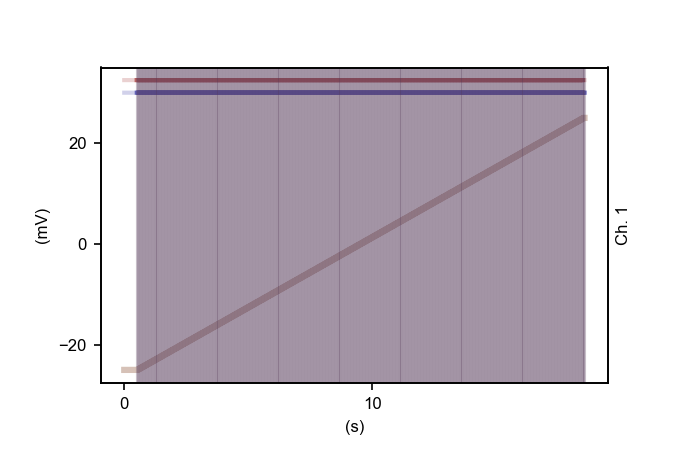

In [24]:
fast_ramp_2.sample_rate(10e3)
fast_ramp_2.start_ramp_voltage(-0.025)
fast_ramp_2.finish_ramp_voltage(0.025)
fast_ramp_2.n_steps(301)  # 30
fast_ramp_2.n_repetitions(1)  # 20
fast_ramp_2.settlement_time(0.005)  # 0.103
fast_ramp_2.lockin_integration_time(0.055)  # 0.021
fast_ramp_2.restart_compensation(100 * fast_ramp_2.settlement_time())

# Convenient vectors for plotting
time_axis_points = fast_ramp_2.get_trigger_moments_vector()
gate_voltage_points = fast_ramp_2.values_vector()

# Sanity check :)
fast_ramp_2.plot_broadbean_sequence()

In [17]:
class AwgLockInVoltageRampSweep(HardwareSweep):
    """
    This class implements "hardware" sweep that is performed by AWG sequencer, 
    and 3 lock-ins are measuring values while AWG is emitting a signal.
    
    Structure of this object:
    * The object of this class holds references to AWG sequencer and to the lock-ins.
    * Moreover, it defines 3 parameters which correspond to the outputs of the 3 lock-ins.
    * The 'run' method implements the actual measurement where lock-ins acquire data
      while the device under measurement is excited by signals from AWG, and the acquired
      data is then available through the 3 parameters presented above.
    """
    
    def __init__(self,
                 name: str,
                 awg_sequencer_obj: Type[AwgSequencer],
                 lockin1: Type[SR86x],
                 lockin2: Type[SR86x],
                 lockin3: Type[SR86x],
                 **kwargs):
        super().__init__(name, **kwargs)
        
        # AWG sequencer
        self.add_submodule(name='awg_sequencer',
                           submodule=awg_sequencer_obj)
        self.delegate_attr_objects = ['awg_sequencer']

        # Lock-in amplifiers
        self.add_submodule(name='lockin1',
                           submodule=lockin1)
        self.add_submodule(name='lockin2',
                           submodule=lockin2)
        self.add_submodule(name='lockin3',
                           submodule=lockin3)
        self._lockins = [self.lockin1, self.lockin2, self.lockin3]
        
        self._capture_variable_name = "X"
        self._setup_capture_config_for_lockins()

        # Parameters that are linked to outputs of lock-in buffers
        self.add_parameter('measured_voltage_at_triggers_lockin_1',
                           DelegateParameter,
                           source=self.lockin1.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 1 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 1 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_2',
                           DelegateParameter,
                           source=self.lockin2.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 2 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 2 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_3',
                           DelegateParameter,
                           source=self.lockin3.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 3 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 3 amplifier"
                           )
        
    @property
    def lockins(self):
        return self._lockins
       
    def _setup_capture_config_for_lockins(self):
        for lockin in self.lockins:
            lockin.input_config('a')  # within "voltage" block
            lockin.buffer.capture_config(self._capture_variable_name)

    def run(self):
        midas_results = []
        try:
            trigger_count = self.awg_sequencer.sequence_gen.n_all_steps()
            
            for lockin in self.lockins:
                lockin.buffer.set_capture_length_to_fit_samples(trigger_count)
                lockin.buffer.start_capture("ONE", "SAMP")
                
            # arm MIDAS to measure
            midas.ch1.frequency(200e6)
            
            self.awg_sequencer.awg.play()
            
            
            
            for lockin in self.lockins:
                
                lockin.buffer.wait_until_samples_captured(trigger_count)
                lockin.buffer.stop_capture()
                lockin.buffer.get_capture_data(trigger_count)  # this loads data from buffer 
                                                              # to driver's "buffer readout" fields in memory
                
                
            #for i in range(20):
                #midas.capture_1d_trace() 
                #midas_results = np.append(midas_results, midas.ch1.magnitude().mean())   
                #print(i, midas_results)
#             # Alternatively, this method could have been returning the data 
#             # instead of using the driver's buffer readout
#             # parameters. But in this case, the occuring boilerplate code
#             # within the measurement context manager should be
#             # taken care of (for example, via Wolfgangs MeasurementExt,
#             # HardwareSweepDetector, etc.)
#             voltage_axis_points_dict = {}
#             for lockin in self.lockins:
#                 lockin_data = lockin.buffer.get_capture_data(trigger_count)
#                 voltage_axis_points_dict[lockin.name] = lockin_data[self._capture_variable_name]
#             return voltage_axis_points_dict
        
        finally:
            self.awg_sequencer.awg.stop()
        #return midas_results

In [25]:
awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)
hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)

In [19]:
awg_sequencer.send_sequence_and_setup_awg()

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [50]:
awg_sequencer.awg.stop()

In [223]:
midas.num_sweeps_2d(awg_sequencer.sequence_gen.n_all_steps())
midas.num_sweeps_2d()

5097476644957847552

In [47]:
awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)
hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)
awg_sequencer.send_sequence_and_setup_awg()
a = [x for x in range(awg_sequencer.sequence_gen.n_all_steps())]
#midas_results = np.zeros((awg_sequencer.sequence_gen.n_all_steps(), 2048))
#midas_results = np.zeros(awg_sequencer.sequence_gen.n_all_steps())
midas.ch1.frequency(200e6)
awg_sequencer.awg.play()
t0 = time.time()
for i in range(awg_sequencer.sequence_gen.n_all_steps()):
    a[i] = midas.capture_1d_trace() 
#b = midas.capture_2d_trace()
    #midas_results[i] = b.mag_phase(1)   
#mag[i],phase[i] = b.mag_phase(1)   
    #print(i, midas_results)
print(time.time()-t0)

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [328]:
mag = np.zeros((awg_sequencer.sequence_gen.n_all_steps(),2048))
pha = np.zeros((awg_sequencer.sequence_gen.n_all_steps(),2048))
for kk in range(awg_sequencer.sequence_gen.n_all_steps()):
    mag[kk,:],pha[kk,:] = a[kk].mag_phase(0)

<IPython.core.display.Javascript object>


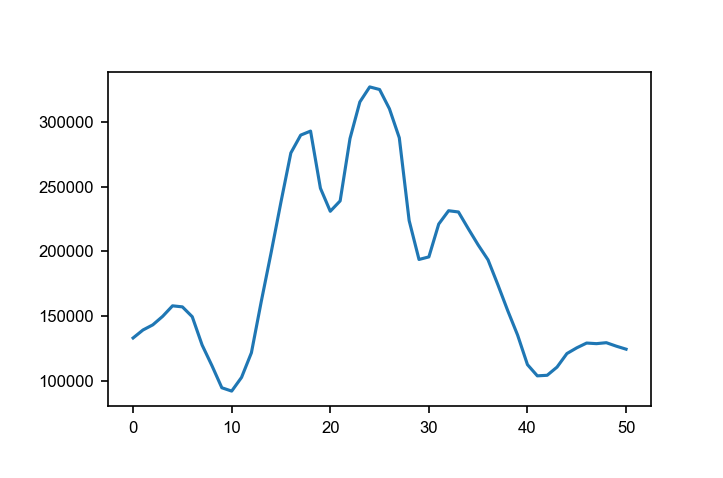

In [329]:
plt.figure()
plt.plot(mag.mean(axis=1))

In [ ]:
awg_sequencer.awg.stop()

In [20]:
transistor_characterizer = VirtualInstrument("transistor_characterizer")

# Define parameters
v_g_param = DelegateParameter(
    'v_g', 
    fast_ramp_2.values_with_repetitions_vector, 
    label='Gate voltage', 
    unit='V'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

i_avg_param = DelegateParameter(
    'i_avg',
    fast_ramp_2.all_repetitions_vector,
    label='Index of gate voltage averaging',
    unit='#'
)
add_parameter_to_instrument(i_avg_param, transistor_characterizer)

v_sd_1_param = DelegateParameter(
    'v_sd_1',
    hwsweeper.measured_voltage_at_triggers_lockin_1,
    label='Source-drain current 1 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_1_param, transistor_characterizer)

v_sd_2_param = DelegateParameter(
    'v_sd_2',
    hwsweeper.measured_voltage_at_triggers_lockin_2,
    label='Source-drain current 2 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_2_param, transistor_characterizer)

v_sd_3_param = DelegateParameter(
    'v_sd_3',
    hwsweeper.measured_voltage_at_triggers_lockin_3,
    label='Source-drain current 3 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_3_param, transistor_characterizer)

f_acq_param = DelegateParameter(
    'f_acq',
    lockin1.frequency,
    label='Lock-in acquisition frequency', 
    unit='Hz'
)
add_parameter_to_instrument(f_acq_param, transistor_characterizer)

station.add_component(transistor_characterizer)

'transistor_characterizer'

In [27]:
#lockin only hard_sweep
exp = select_experiment('V0_0113A', 'lockin_RF_conductance')

measurement = Measurement(exp)
# measurement.write_period = 2

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(ivvi_setup.dac3)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param,ivvi_setup.dac3))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param,ivvi_setup.dac3))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param,ivvi_setup.dac3))
#measurement.register_custom_parameter('midas_results', setpoints=(v_g_param, i_avg_param))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())

# Perform the experiment and save acquired data
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    t0 = time.time()
    # The "hardware sweep"
    for BG in np.linspace(-3.2, -3.8, 61):
        ivvi_setup.dac3(BG)
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields

        g1_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_1_points - dev1_rs)
        g2_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_2_points - dev2_rs)
        g3_points = -12906/(dev1_Vac*ivvi_setup.M1b_gain()/source_drain_voltage_3_points - dev3_rs)

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (ivvi_setup.dac3, BG),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, g1_points),
            (v_sd_2_param, g2_points),
            (v_sd_3_param, g3_points),
            #('midas_results', mres),
        )

print(time.time()-t0)
# Convenient to have for plotting
run_id_of_data = data_saver.run_id

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 443
1224.796627998352


In [26]:
#midas only hard sweep
exp = select_experiment('V0_0113A', 'midas_hard_sweep')

lockin1.amplitude(0.15)
yoko.voltage(0)
midas.ch1.frequency(200e6)
midas.ch2.frequency(233e6)
ivvi_setup.dac3(-3.2) #BG
awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)
hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)
awg_sequencer.send_sequence_and_setup_awg()

meas = Measurement(exp)

meas.register_parameter(v_g_param)
# meas.register_parameter(midas.ch1.frequency)
#meas.register_custom_parameter('att')
#meas.register_custom_parameter('frq')
#meas.register_parameter(ivvi_setup.dac1)
meas.register_parameter(ivvi_setup.dac3)
#meas.register_parameter(yoko.voltage)
# meas.register_custom_parameter('idx')
#meas.register_custom_parameter('logmag', setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('logmag', setpoints=[ivvi_setup.dac1, ])
#meas.register_custom_parameter('phase', setpoints=[yoko.voltage, 'frq'])
meas.register_custom_parameter('logmag_dev48', setpoints=[v_g_param,ivvi_setup.dac3])
meas.register_custom_parameter('phase_dev48', setpoints=[v_g_param,ivvi_setup.dac3])
meas.register_custom_parameter('logmag_dev12', setpoints=[v_g_param,ivvi_setup.dac3])
meas.register_custom_parameter('phase_dev12', setpoints=[v_g_param,ivvi_setup.dac3])
#meas.register_parameter(midas.ch1.magnitude, setpoints=[midas.ch1.frequency, 'idx'])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[ivvi_setup.dac3,'frq'])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[ivvi_setup.dac3,'frq'])
#meas.register_parameter(ivvi_setup.g3_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_parameter(ivvi_setup.g2_measurement, setpoints=[yoko.voltage, 'frq'])
#meas.register_custom_parameter('lockin3_X', setpoints=[ivvi_setup.dac1, ])

meas.write_period = 1

with meas.run() as datasaver:
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    #for f in frqs:
        #midas.ch1.frequency(f)
    mag_dev12 = np.zeros(awg_sequencer.sequence_gen.n_all_steps())
    phase_dev12 = np.zeros(awg_sequencer.sequence_gen.n_all_steps())
    mag_dev48 = np.zeros(awg_sequencer.sequence_gen.n_all_steps())
    phase_dev48 = np.zeros(awg_sequencer.sequence_gen.n_all_steps())
    
    
    for BG in np.linspace(-3.2,-3.8,61):
        ivvi_setup.dac3(BG)
        awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)
        hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)
        awg_sequencer.send_sequence_and_setup_awg()
        awg_sequencer.awg.play()
        for i in range(awg_sequencer.sequence_gen.n_all_steps()):
            #print(i)
        #for BG in np.linspace(-3.2, -3.8, 51):
            #ivvi_setup.dac3(BG)
        #for bias in np.linspace(-0.6e-3, 0.6e-3, 1001):
            #ivvi_setup.dac3(BG)
            #yoko.voltage(bias)
            #for f in frqs:
            #midas.ch1.frequency(f)
            midas.capture_1d_trace()
            mag_dev12[i] = midas.ch1.magnitude().mean()**2.
            mag_dev12[i] = np.log10(mag_dev12[i])
            phase_dev12[i] = midas.ch1.phase().mean()

            mag_dev48[i] = midas.ch2.magnitude().mean()**2.
            mag_dev48[i] = np.log10(mag_dev48[i])
            phase_dev48[i] = midas.ch2.phase().mean()
            #lockin3_X = lockin3.X()

        all_gate_voltage_points = v_g_param.get()
        datasaver.add_result(
            #(yoko.voltage, bias),
            (ivvi_setup.dac3, BG),
            (v_g_param, all_gate_voltage_points),
            ('logmag_dev48', mag_dev48),
            ('phase_dev48', phase_dev48),
            ('logmag_dev12', mag_dev12),
            ('phase_dev12', phase_dev12),)
            #('lockin3_X', lockin3_X))
            #(ivvi_setup.g3_measurement, ivvi_setup.g3_measurement()),
            #(ivvi_setup.g2_measurement, ivvi_setup.g2_measurement()))
    awg_sequencer.awg.stop()

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 442
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Waveforms

In [103]:
ivvi.set_dacs_zero()

In [97]:
ami_y.ramp_to(0)

In [93]:
ami_z.ramp_to(0)

In [102]:
ami_y.field()

0.0

In [383]:
dev3_Vac

1.5000000595999999e-05